<a href="https://colab.research.google.com/github/ipeirotis/autoencoders_census/blob/main/measure_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Autoencoders and Data Quality for Tabular Data**

In [1]:
!rm -rf autoencoders_census
!git clone https://github.com/ipeirotis/autoencoders_census.git
%cd autoencoders_census

Cloning into 'autoencoders_census'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 436 (delta 40), reused 2 (delta 2), pack-reused 366
Receiving objects: 100% (436/436), 43.08 MiB | 22.28 MiB/s, done.
Resolving deltas: 100% (254/254), done.
/content/autoencoders_census


In [2]:
from google.colab import auth

# Login using the account that has access to the Google project
# in order to access the resources for the project
auth.authenticate_user()

In [3]:
# This code imports the DataTransformer object from
# the notebook pandas2vector.ipynb
!pip install -q import_ipynb keras-tuner
import import_ipynb
from pandas2vector import Table2Vector
from data_loader import DataLoader
from autoencoder import AutoencoderModel

importing Jupyter notebook from pandas2vector.ipynb
importing Jupyter notebook from data_loader.ipynb
importing Jupyter notebook from autoencoder.ipynb


# Data Source

The used data stems from the Youth Risk Behavior Surveillance System by CDC (Centers for Disease Control and Prevention). It includes data on a set of surveys that track behaviors that can lead to poor health in students grades 9 through 12. [Here](https://www.cdc.gov/healthyyouth/data/yrbs/data.htm) is the link to the dataset.

Note: The dataset is updated every two years. We use the 2017 version of the national high school YRBS dataset.

## Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix
from pandas.api.types import is_numeric_dtype
from matplotlib.offsetbox import TransformedBbox

In [6]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
from numpy.random import uniform
from numpy.random import seed

In [7]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras import backend as K
from keras import Model

In [8]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras

# Load Original Dataset

In [9]:

# Data Source
data_loader = DataLoader()

project_data, variable_types  = data_loader.load_2017()



In [10]:
project_data.shape

(14765, 98)

In [11]:
project_data.dropna().shape

(14765, 98)

# Vectorizing the data set

In [12]:
# Data Transformation
vectorizer = Table2Vector(variable_types)


# Without indicator variables for missingness
vectorized_df = vectorizer.vectorize_table(project_data)

In [13]:
assert( vectorizer.tabularize_vector(vectorized_df).shape == project_data.shape )

# Autoencoder loading

In [14]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope
import gcsfs




# Define the path to the file on GCS
gcs_model_path = "gs://autoencoder_census_models/best_parameters_autoencoder.keras"

# Define the local path where the model will be downloaded
local_model_path = "best_parameters_autoencoder.keras"

# Create a GCS filesystem object using your project ID
fs = gcsfs.GCSFileSystem(project='autoencoder-census')

# Download the model file from GCS
with fs.open(gcs_model_path, 'rb') as gcs_file:
    with open(local_model_path, 'wb') as local_file:
        local_file.write(gcs_file.read())


# Initialize AutoencoderModel with attribute_cardinalities
# to use the custom loss function
attr_cardinalities = list(project_data.describe().T['unique'].values)
autoencoder_model = AutoencoderModel(attr_cardinalities)


# Load the model from the local file
model = load_model(local_model_path)




## Making Predictions and Filling in the Missing Values


In [15]:
import numpy as np

# Fill the missing values with some initial guess. Here, the median of each column is used.
filled = vectorized_df.fillna(vectorized_df.median())

# Define a condition for stopping the iteration
epsilon = 1e-5
old_filled = None

while old_filled is None or np.abs(filled - old_filled).sum().sum() > epsilon:
  # Save the old filled DataFrame for convergence check
  old_filled = filled.copy()

  # Run the data through the autoencoder, which will return a complete version of the data.
  predicted = model.predict(filled)

  # Replace the initially guessed values in the original data with the corresponding values from the autoencoder's output. But keep the observed values unchanged.
  mask = vectorized_df.isna()
  filled[mask] = np.where(mask, predicted, filled)


462/462 [==============================] - 7s 7ms/step


In [16]:
filled

age__12 years old or younger  age__13 years old  age__14 years old  \
0                               0.0                0.0                0.0   
1                               0.0                0.0                0.0   
2                               0.0                0.0                0.0   
3                               0.0                0.0                0.0   
4                               0.0                0.0                0.0   
...                             ...                ...                ...   
14760                           0.0                0.0                0.0   
14761                           0.0                0.0                0.0   
14762                           0.0                0.0                0.0   
14763                           0.0                0.0                0.0   
14764                           0.0                0.0                0.0   

       age__15 years old  age__16 years old  age__17 years old  \
0                    0.0                0.0                0.0   
1                    0.0                0.0                0.0   
2                    0.0                0.0                0.0   
3                    0.0                0.0                0.0   
4                    0.0                0.0                0.0   
...                  ...                ...                ...   
14760                0.0                0.0                0.0   
14761                0.0                0.0                0.0   
14762                0.0                0.0                0.0   
14763                0.0                0.0                0.0   
14764                0.0                0.0                0.0   

       age__18 years old or older  age__nan  sex__Female  sex__Male  ...  \
0                             0.0       1.0          0.0        0.0  ...   
1                             0.0       1.0          0.0        0.0  ...   
2                             0.0       1.0          0.0        0.0  ...   
3                             0.0       1.0          0.0        0.0  ...   
4                             0.0       1.0          0.0        0.0  ...   
...                           ...       ...          ...        ...  ...   
14760                         1.0       0.0          1.0        0.0  ...   
14761                         1.0       0.0          1.0        0.0  ...   
14762                         1.0       0.0          1.0        0.0  ...   
14763                         1.0       0.0          1.0        0.0  ...   
14764                         1.0       0.0          1.0        0.0  ...   

       stweight_cat__missing  stweight_cat__normal  stweight_cat__top-extreme  \
0                        1.0                   0.0                        0.0   
1                        1.0                   0.0                        0.0   
2                        1.0                   0.0                        0.0   
3                        1.0                   0.0                        0.0   
4                        1.0                   0.0                        0.0   
...                      ...                   ...                        ...   
14760                    1.0                   0.0                        0.0   
14761                    1.0                   0.0                        0.0   
14762                    1.0                   0.0                        0.0   
14763                    0.0                   1.0                        0.0   
14764                    1.0                   0.0                        0.0   

       bmi_cat__bottom-extreme  bmi_cat__missing  bmi_cat__normal  \
0                          0.0               1.0              0.0   
1                          0.0               1.0              0.0   
2                          0.0               1.0              0.0   
3                          0.0               1.0              0.0   
4                          0.0               1.0          

Now that we have filled in the original dataset with the most likely values for their missing values, we run the Autoencoder on the filled vectorized dataset.

In [17]:
predicted = pd.DataFrame(model.predict(filled))
predicted.columns = filled.columns
predicted

462/462 [==============================] - 3s 6ms/step


age__12 years old or younger  age__13 years old  age__14 years old  \
0                          0.002158           0.000009           0.000364   
1                          0.000739           0.000187           0.001513   
2                          0.072804           0.000484           0.011782   
3                          0.001603           0.000062           0.000212   
4                          0.000015           0.000444           0.002342   
...                             ...                ...                ...   
14760                      0.349649           0.001499           0.004304   
14761                      0.950131           0.000099           0.001682   
14762                      0.515384           0.002122           0.017406   
14763                      0.000326           0.000045           0.000026   
14764                      0.141192           0.001085           0.001052   

       age__15 years old  age__16 years old  age__17 years old  \
0               0.040148           0.280721           0.140852   
1               0.024379           0.069677           0.029296   
2               0.184326           0.319929           0.117722   
3               0.012750           0.114308           0.112990   
4               0.049758           0.073775           0.012357   
...                  ...                ...                ...   
14760           0.014696           0.057766           0.333292   
14761           0.003400           0.011774           0.023732   
14762           0.081395           0.171213           0.163538   
14763           0.000483           0.022282           0.657454   
14764           0.005377           0.044820           0.377301   

       age__18 years old or older  age__nan  sex__Female  sex__Male  ...  \
0                        0.011154  0.524595     0.387606   0.059416  ...   
1                        0.006716  0.867493     0.113316   0.010237  ...   
2                        0.018810  0.274143     0.572062   0.072926  ...   
3                        0.012941  0.745133     0.260794   0.079600  ...   
4                        0.001165  0.860144     0.266116   0.026435  ...   
...                           ...       ...          ...        ...  ...   
14760                    0.226717  0.012077     0.428764   0.377495  ...   
14761                    0.004964  0.004217     0.044591   0.710789  ...   
14762                    0.011488  0.037454     0.593840   0.243176  ...   
14763                    0.319174  0.000210     0.928628   0.071020  ...   
14764                    0.413085  0.016087     0.454008   0.242230  ...   

       stweight_cat__missing  stweight_cat__normal  stweight_cat__top-extreme  \
0                   0.999989              0.000011               4.434761e-07   
1                   0.999973              0.000023               2.226475e-06   
2                   0.999922              0.000066               1.264528e-06   
3                   0.999989              0.000011               1.125039e-07   
4                   0.999967              0.000033               8.208314e-08   
...                      ...                   ...                        ...   
14760               0.982104              0.016793               9.644344e-04   
14761               0.999762              0.000086               1.392771e-04   
14762               0.998699              0.001094               1.949897e-04   
14763               0.001766              0.997820               1.747962e-07   
14764               0.989794              0.008809               1.295904e-03   

       bmi_cat__bottom-extreme  bmi_cat__missing  bmi_cat__normal  \
0                     0.000054          0.999073         0.000786   
1                     0.000368          0.997942         0.001343   
2                     0.000535          0.997251         0.002106   
3                     0.000127          0.999362         0.000505   
4                     0.000018          0.998809         0

In [18]:
tabular_from_predicted = vectorizer.tabularize_vector(predicted)

## Visualization of the original vs reconstructed

In [19]:
import matplotlib.pyplot as plt

def create_scatterplot_for_numeric(original_df, predicted_df, numeric_attr):
  plt.figure(figsize=(10, 6))  # Create a new figure with a particular size
  plt.scatter(original_df[numeric_attr], predicted_df[numeric_attr], s=1)  # Create a scatterplot
  plt.xlabel(f'Original Data ({numeric_attr})')  # Set the x-axis label
  plt.ylabel(f'Reconstructed Data ({numeric_attr})')  # Set the y-axis label
  plt.title(f'Scatterplot for {numeric_attr}')  # Set the plot title
  plt.show()  # Display the plot

for v in variable_types.keys():
  if variable_types[v] == 'numeric':
    print(v)
    create_scatterplot_for_numeric(project_data, tabular_from_predicted, v)



age


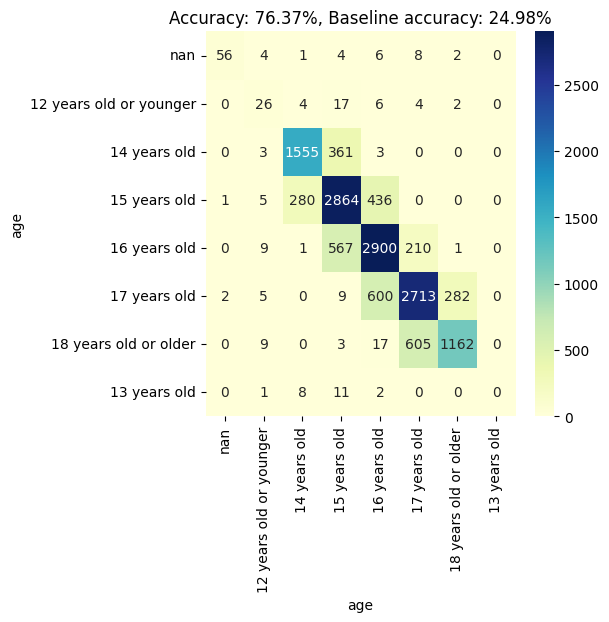

sex


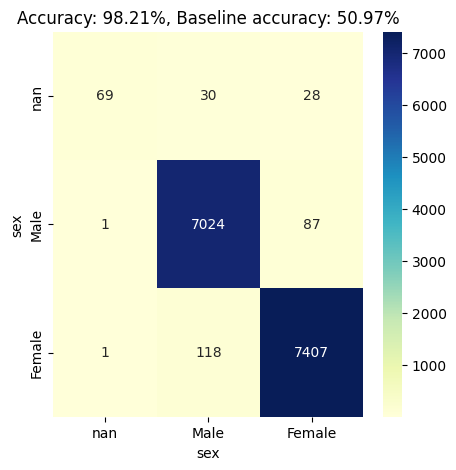

grade


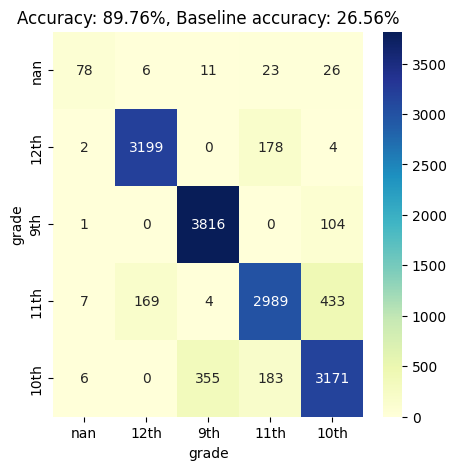

Hispanic_or_Latino


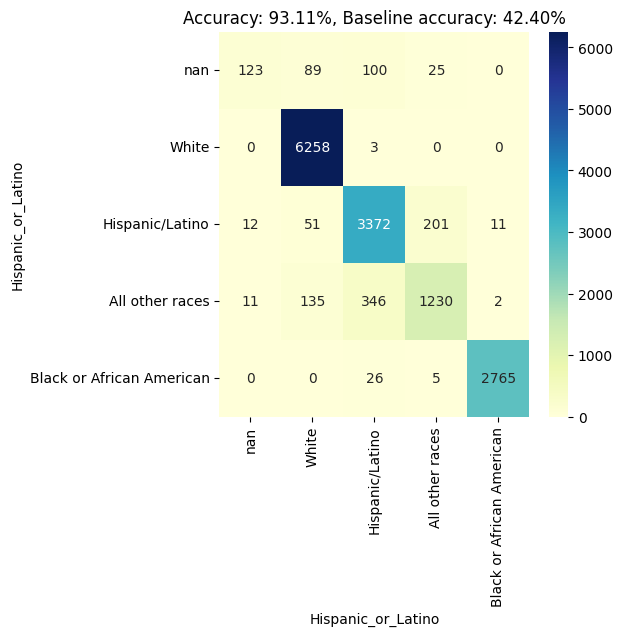

race


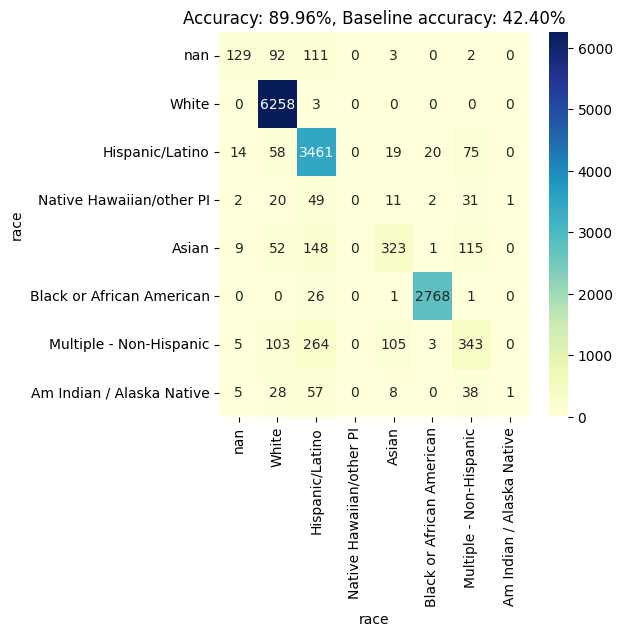

obese


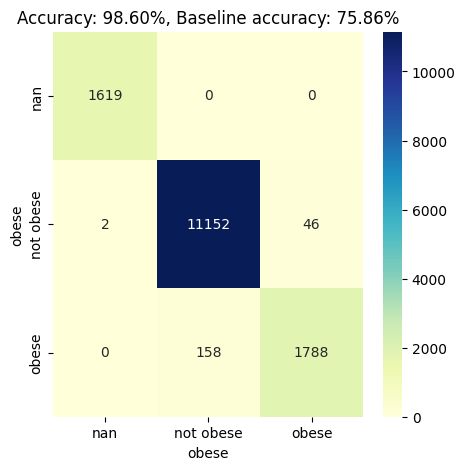

overweight


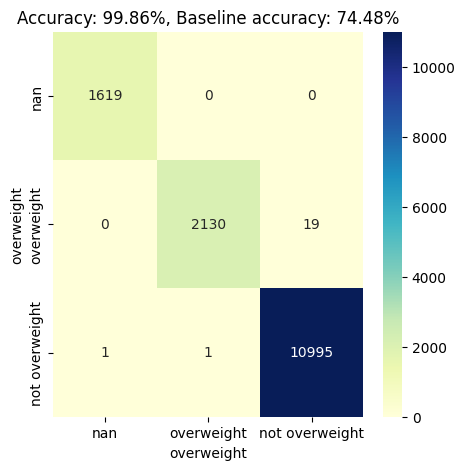

sexual_identity


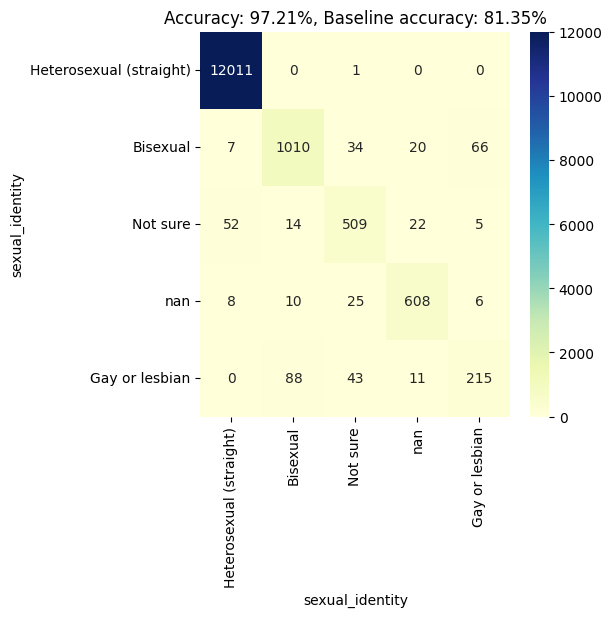

sex/sexual_contacts


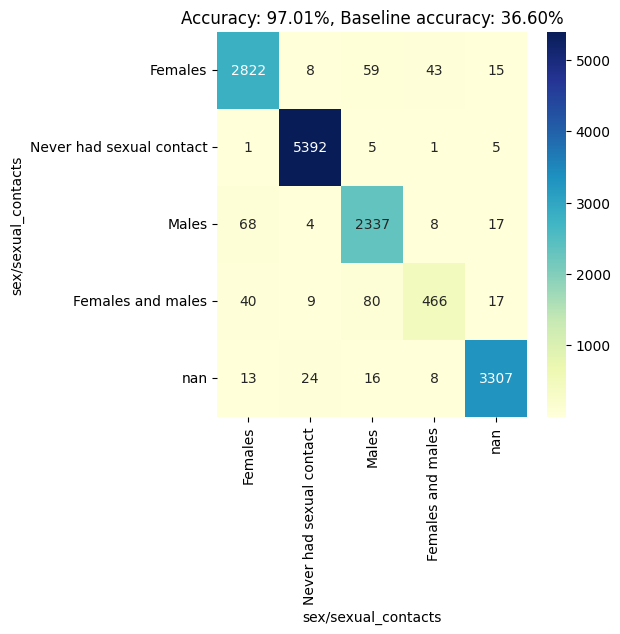

sexid


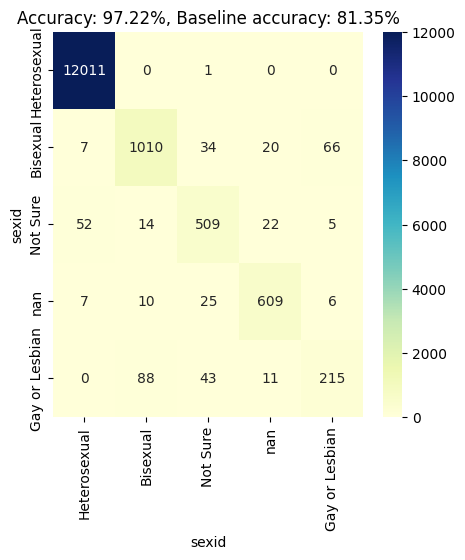

sexid2


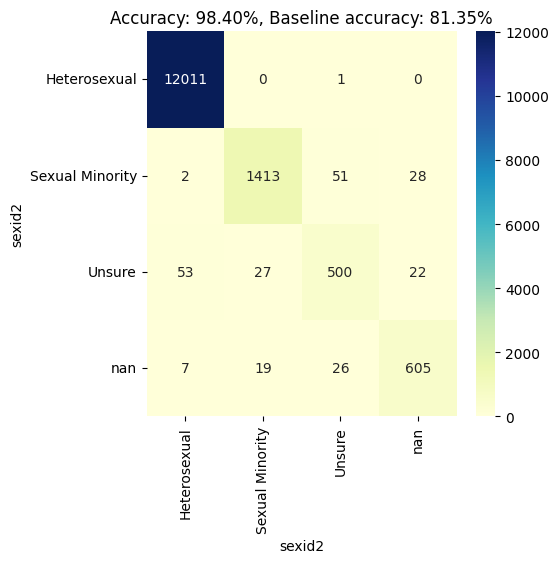

sexpart


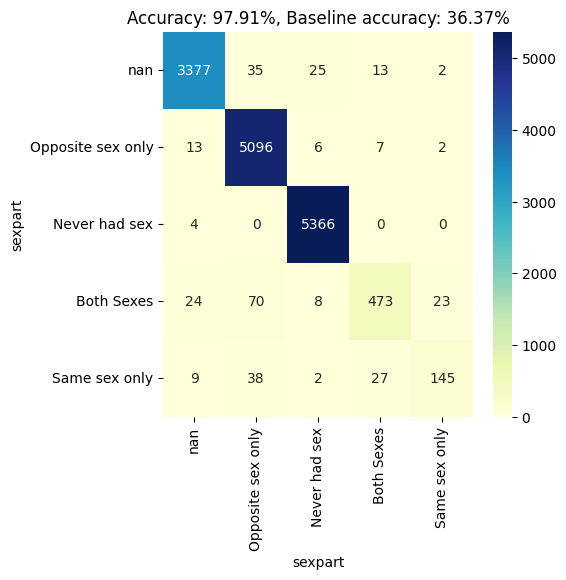

sexpart2


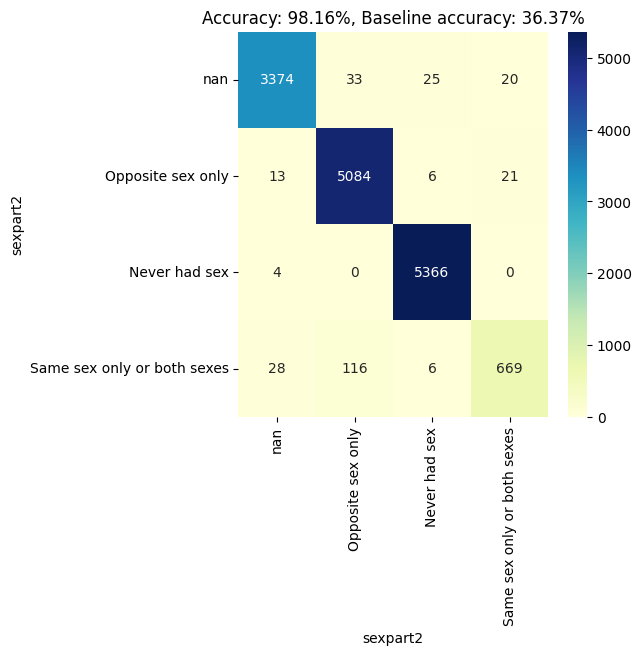

seat_belt_use


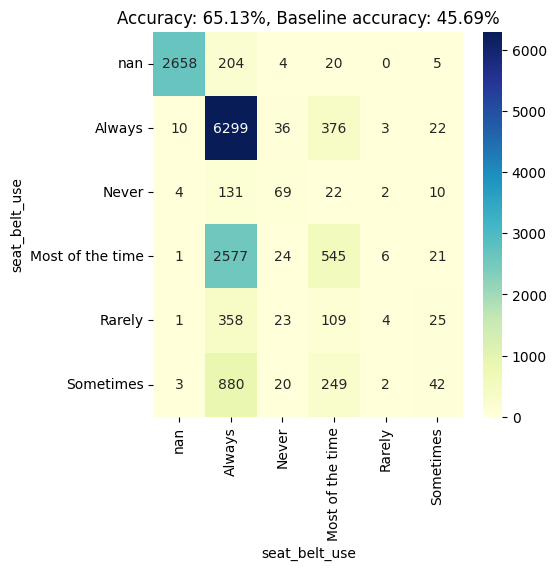

riding_with_a_drinking_driver


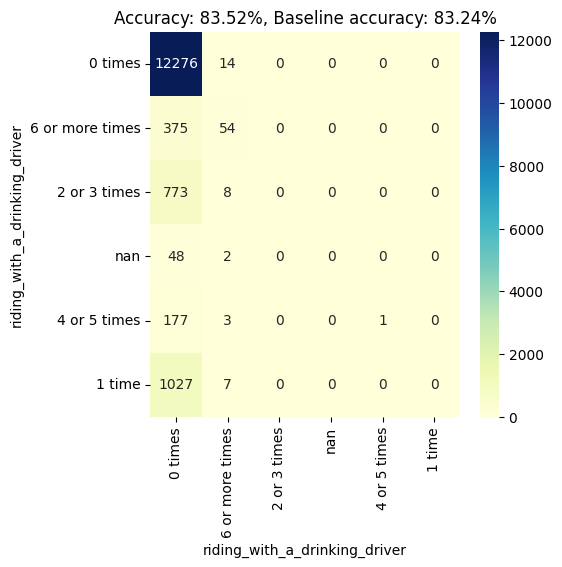

drinking_and_driving


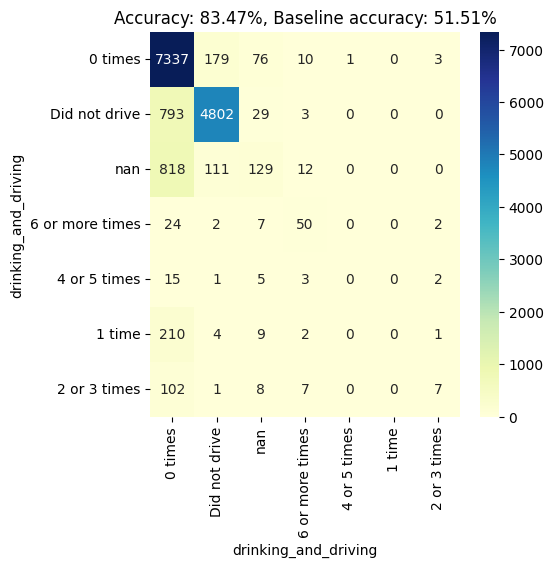

texting_and_driving


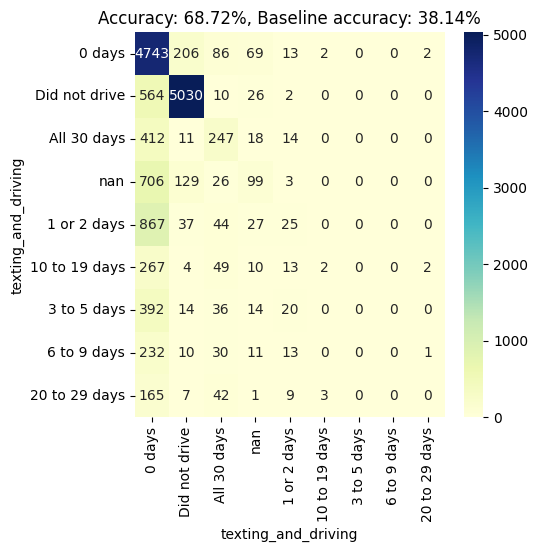

weapon_carrying


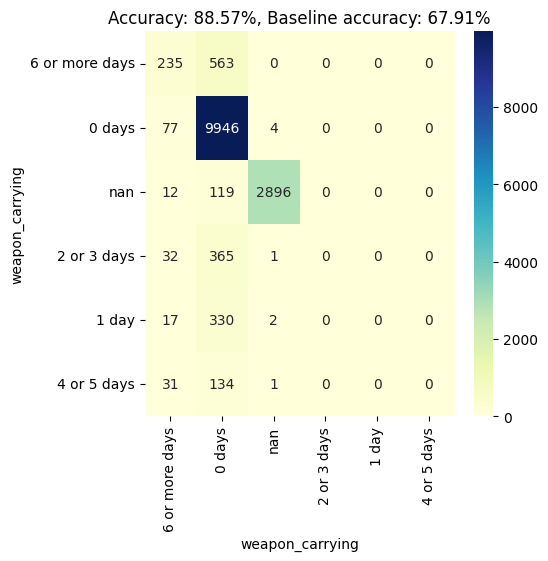

weapon_carrying_at_school


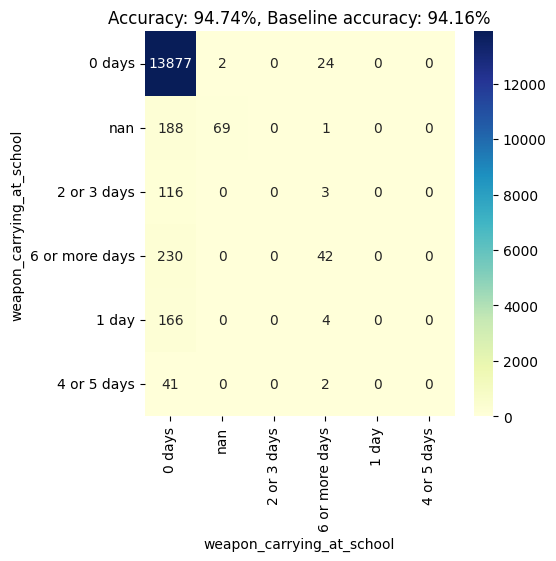

safety_concerns_at_school


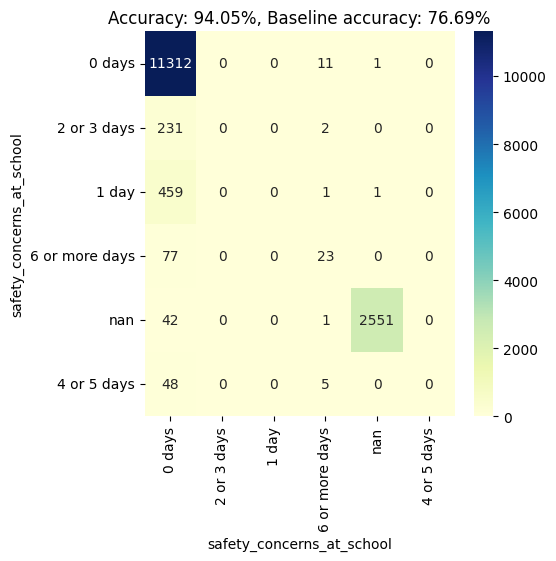

threatened_at_school


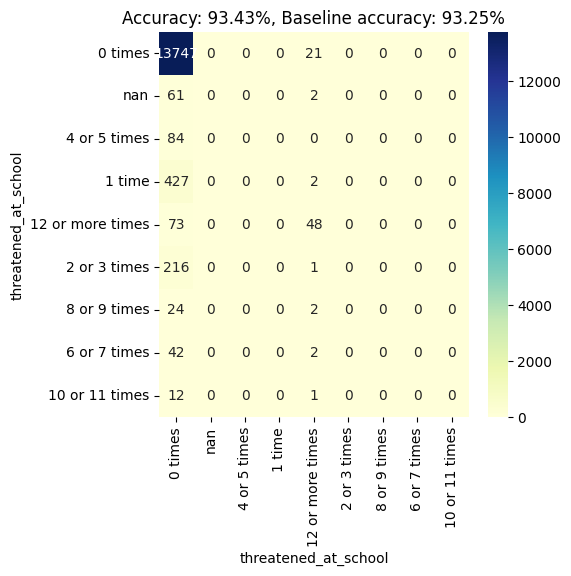

physical_fighting


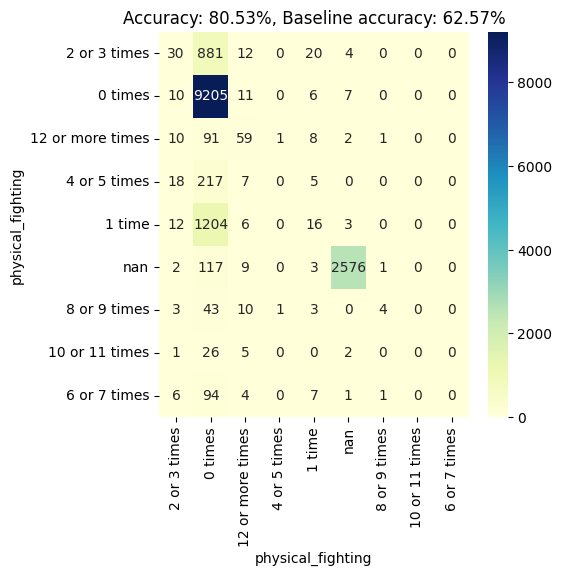

physical_fighting_at_school


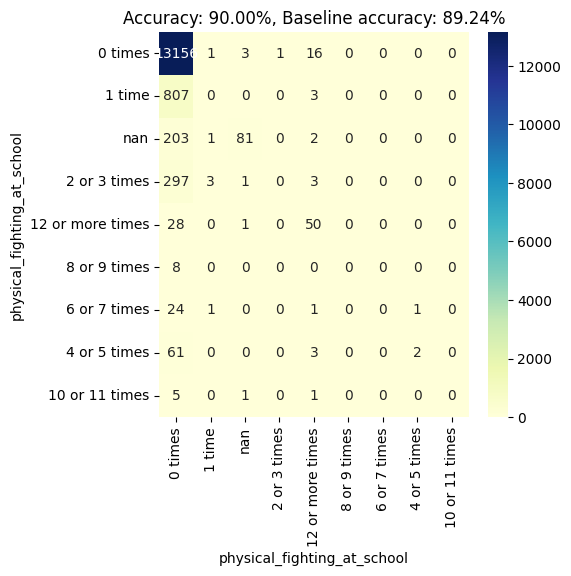

forced_sexual_intercourse


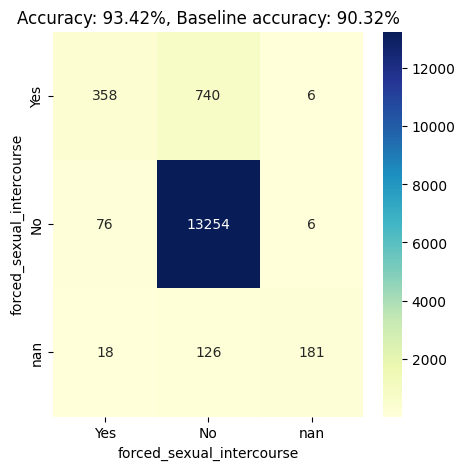

sexual_dating_violence


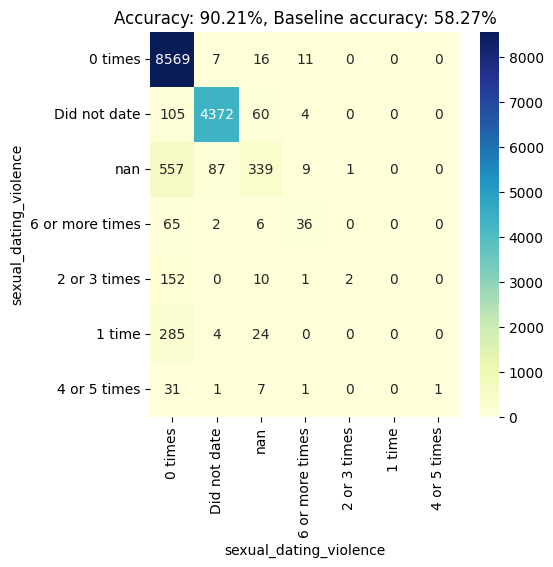

physical_dating_violence


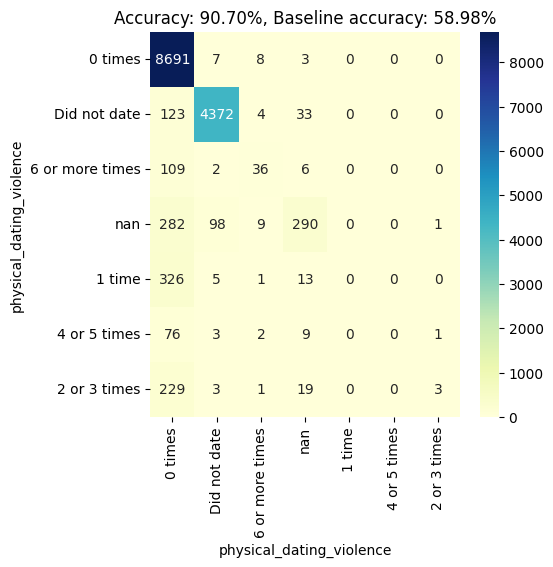

bullying_at_school


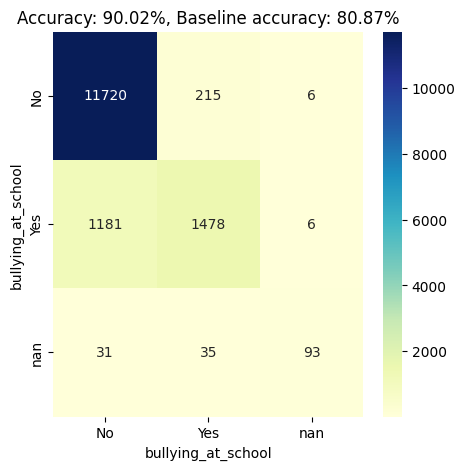

electronic_bullying


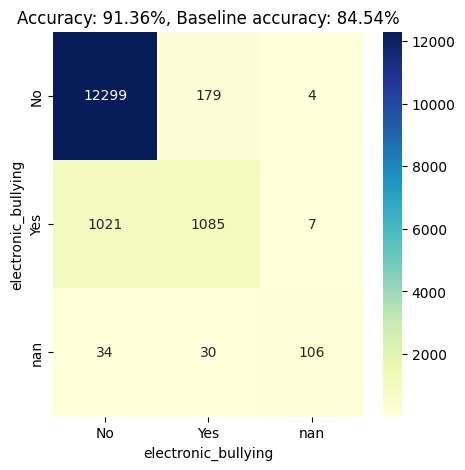

sad_or_hopeless


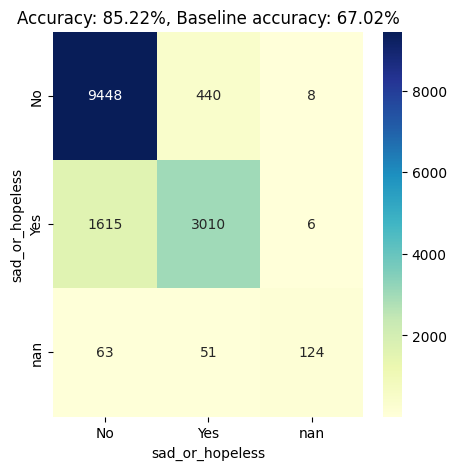

considered_suicide


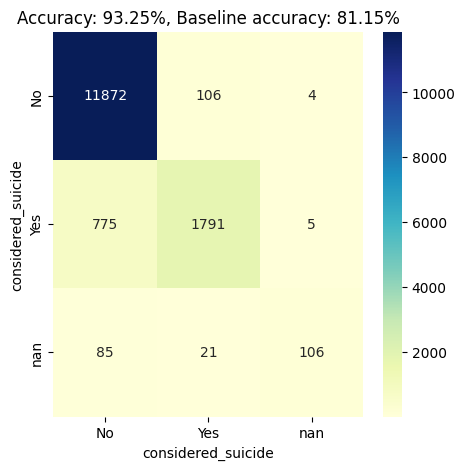

made_a_suicide_plan


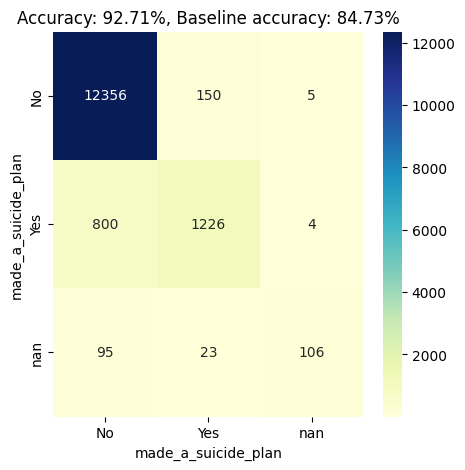

attempted_suicide


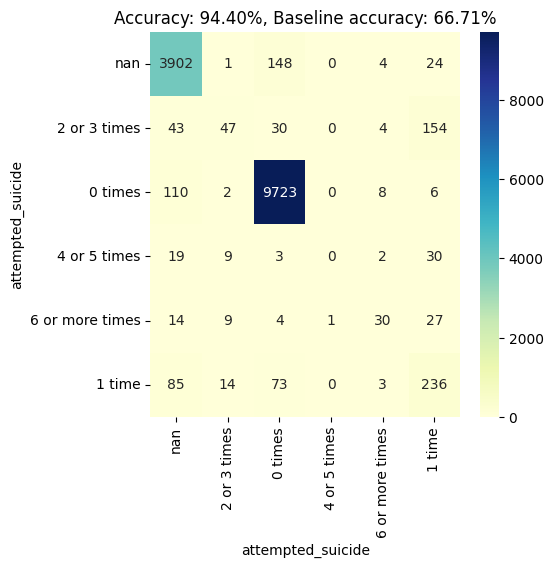

injurious_suicide_attempt


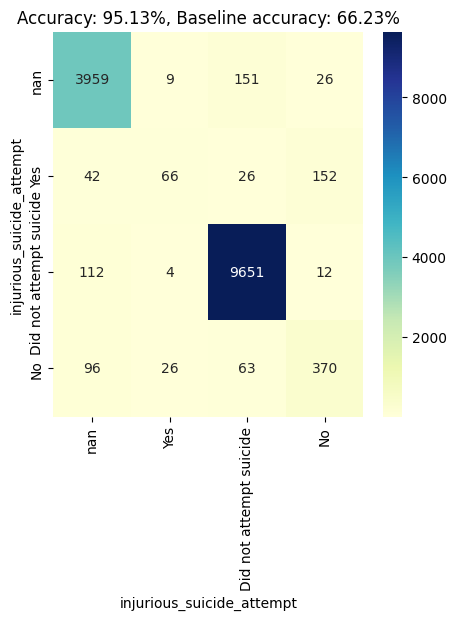

ever_cigarette_use


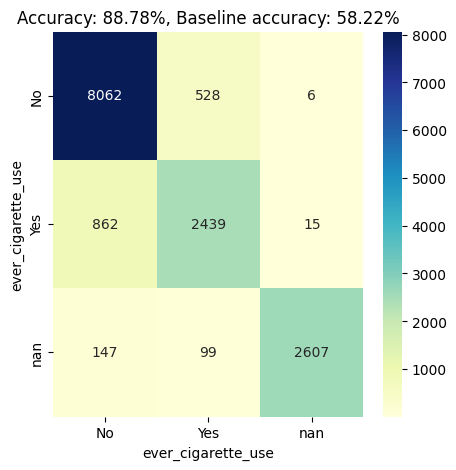

current_cigarette_use


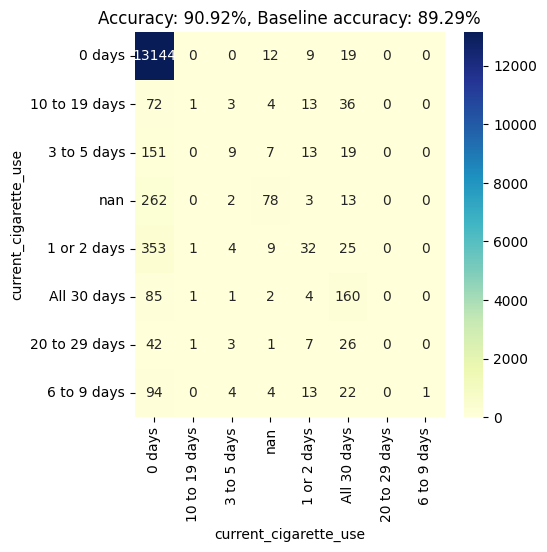

smoking_amounts_per_day


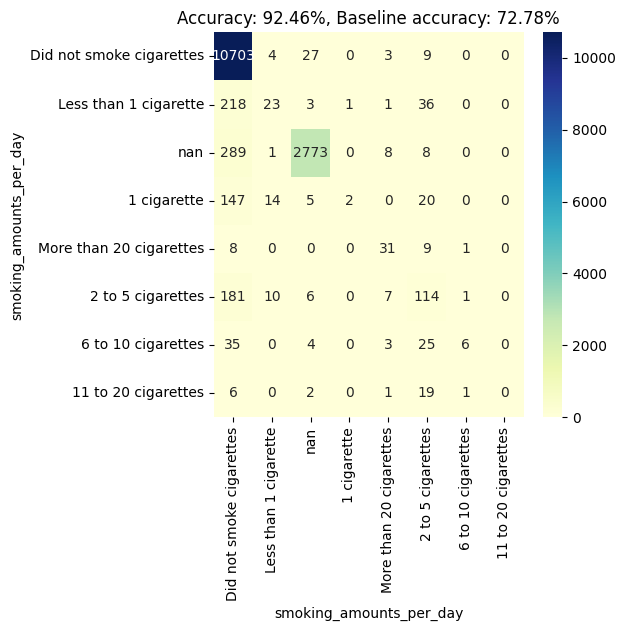

electronic_vapor_product_use


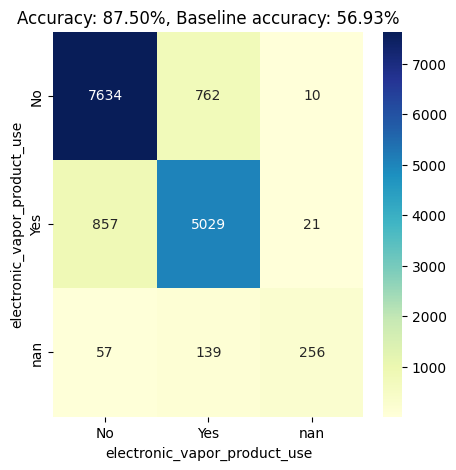

current_electronic_vapor_product_use


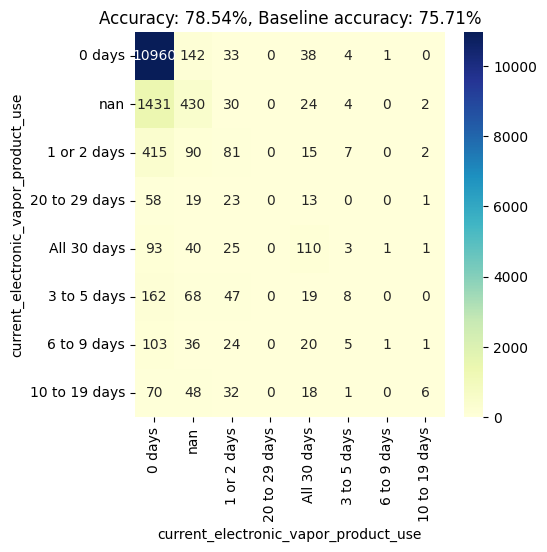

current_cigar_use


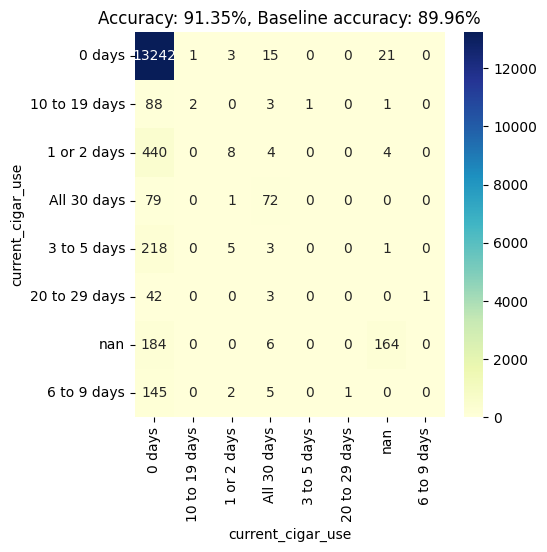

ever_alcohol_use


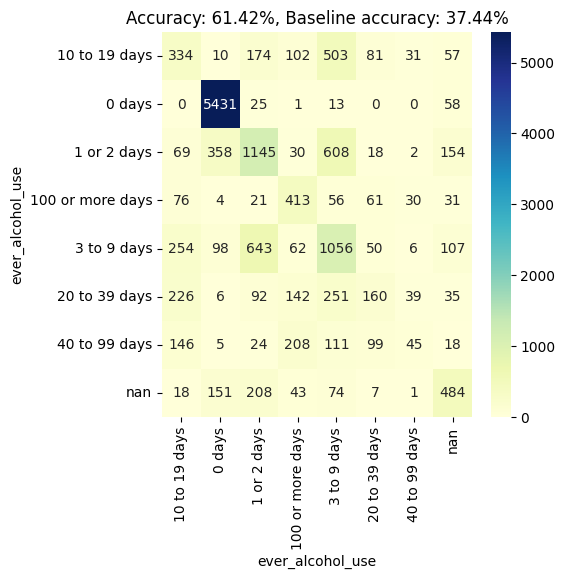

initiation_of_alcohol_use


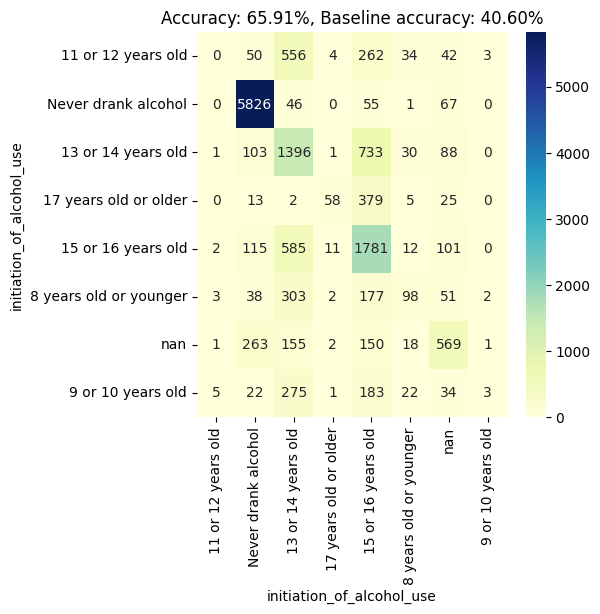

current_alcohol_use


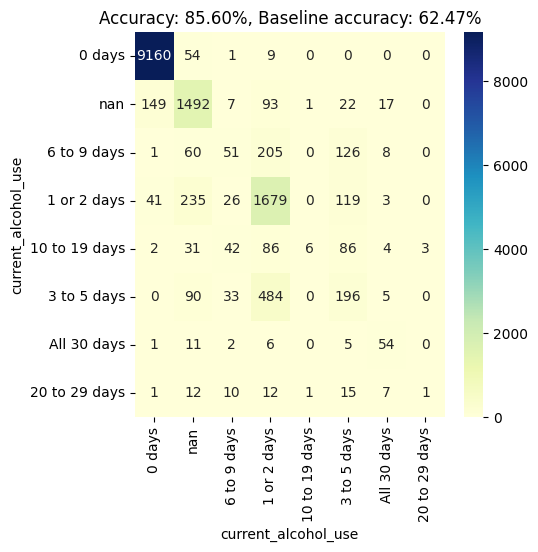

source_of_alcohol


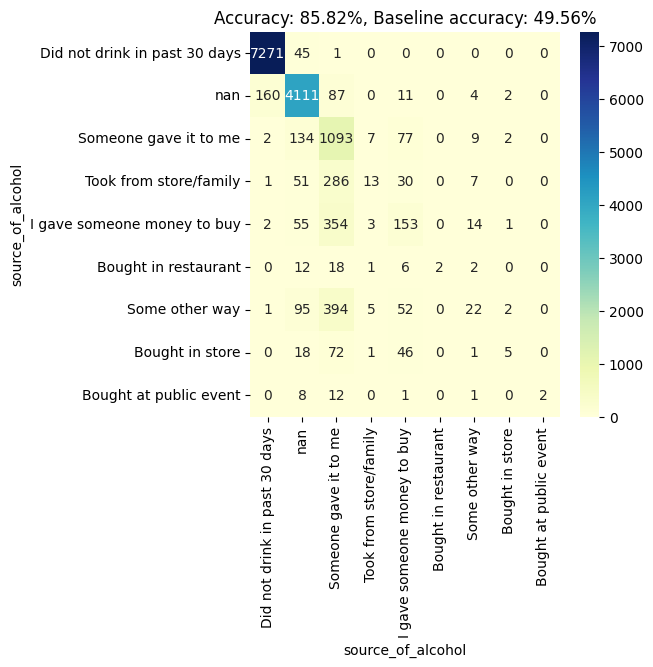

largest_number_of_drinks


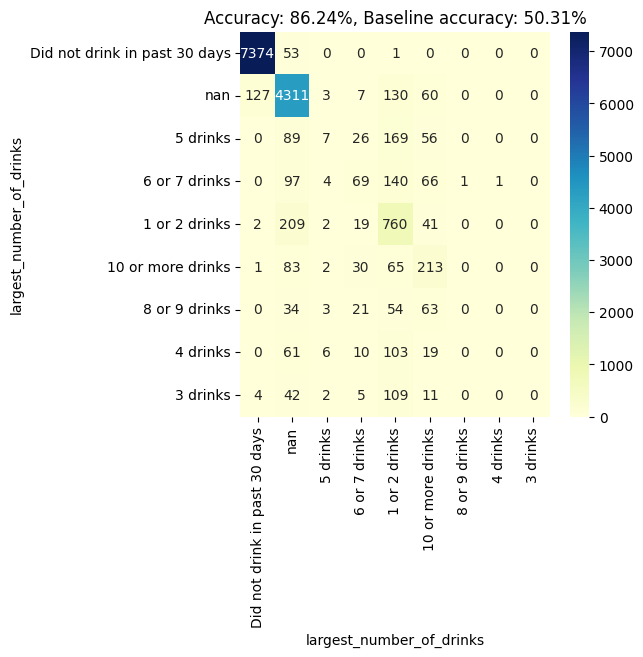

ever_marijuana_use


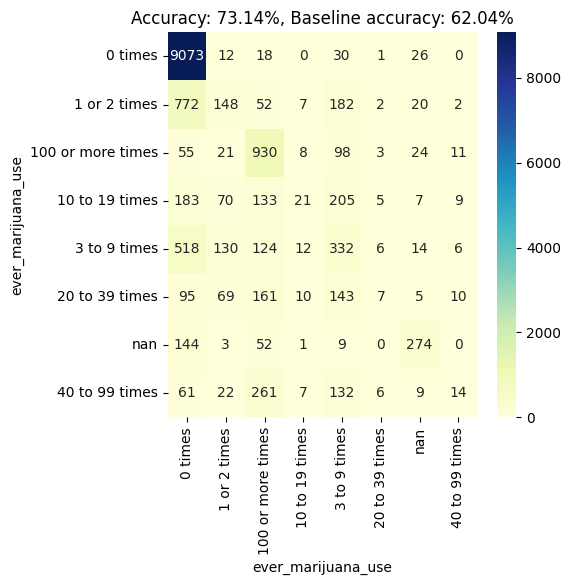

initiation_of_marijuana_use


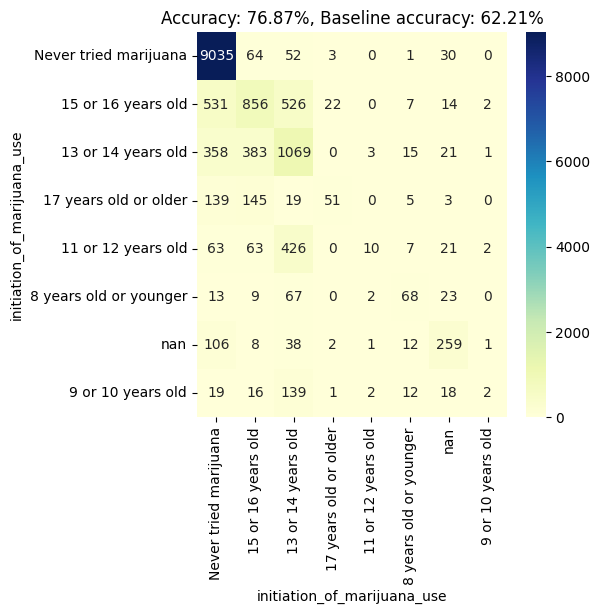

current_marijuana_use


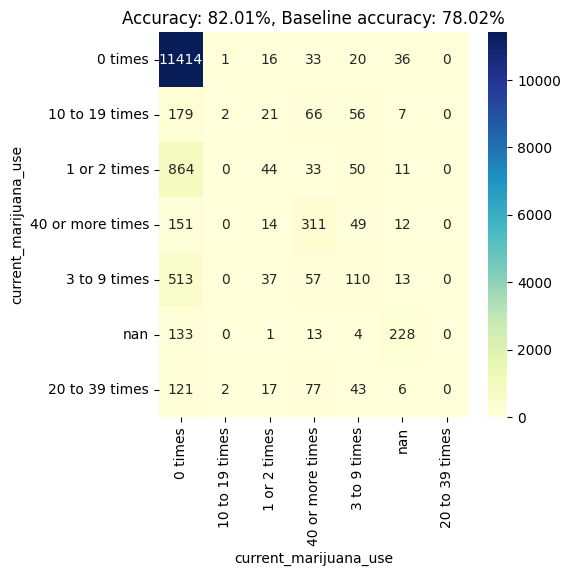

ever_cocaine_use


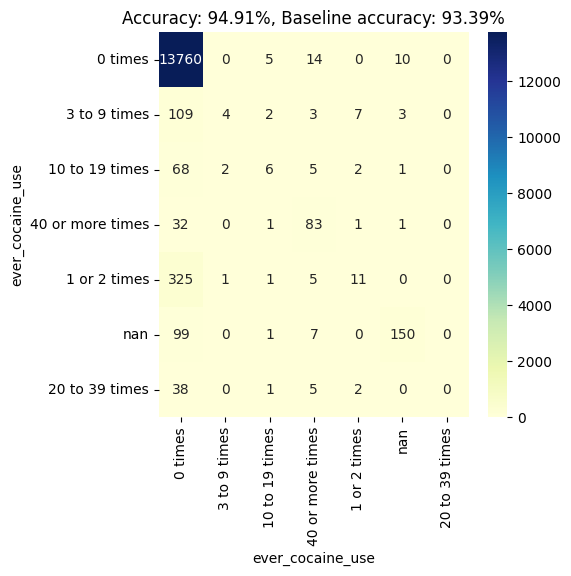

ever_inhalant_use


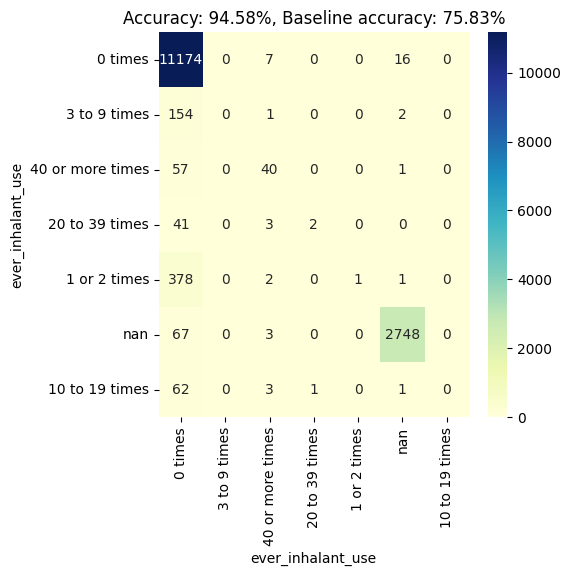

ever_heroin_use


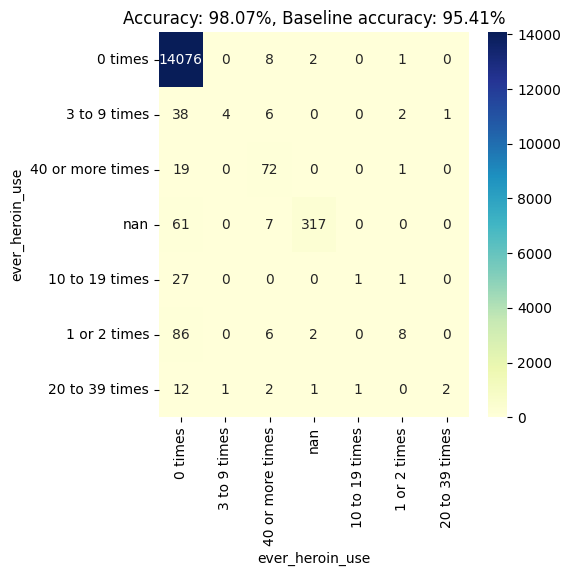

ever_methamphetamine_use


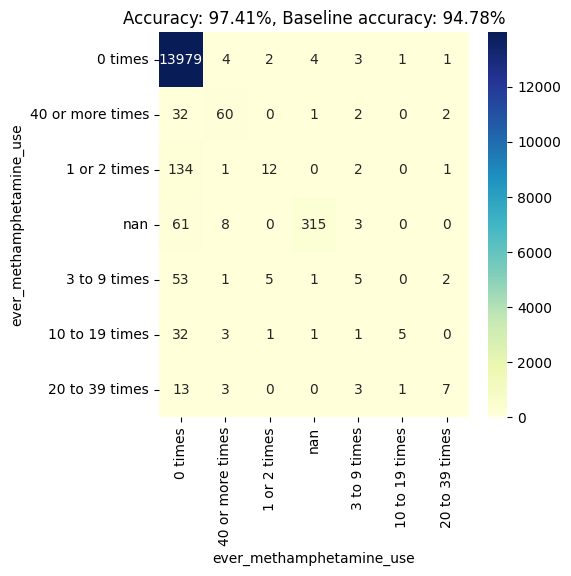

ever_ecstasy_use


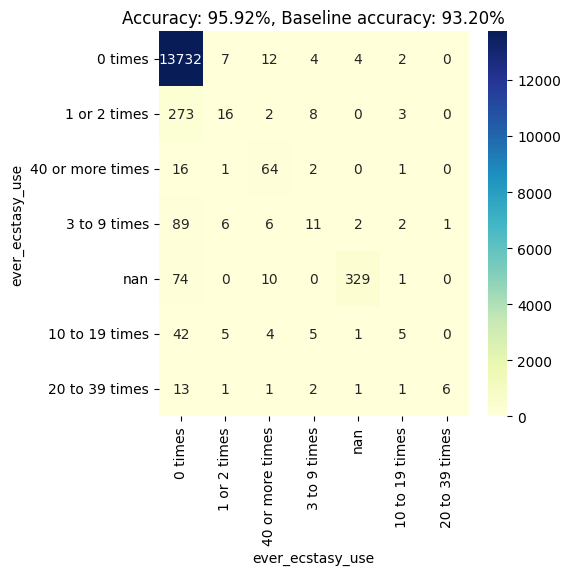

ever_synthetic_marijuana_use


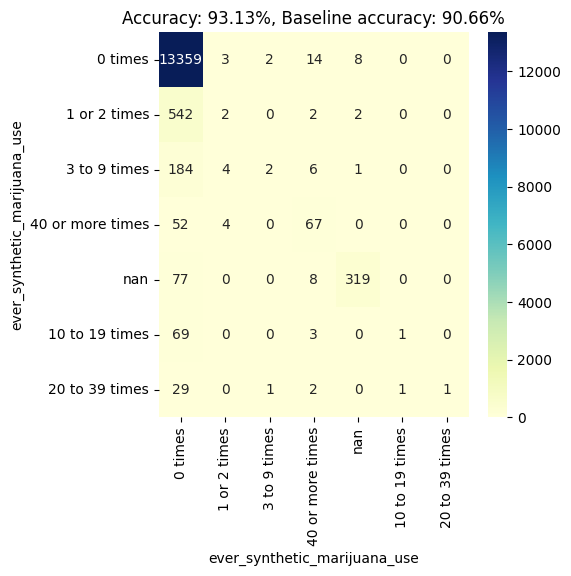

ever_steroid_use


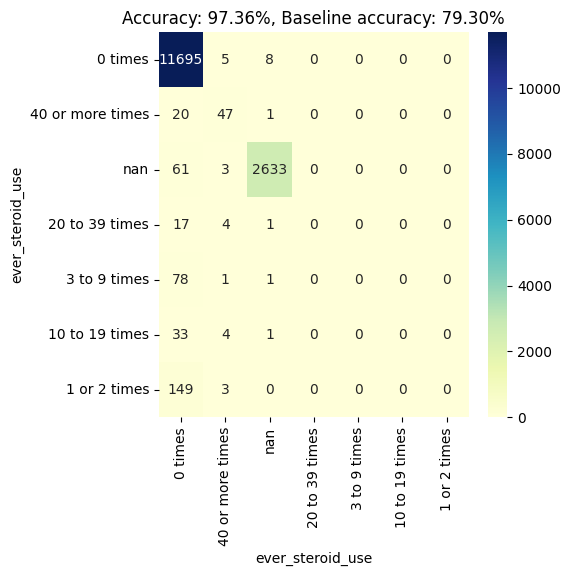

illegal_injected_drug_use


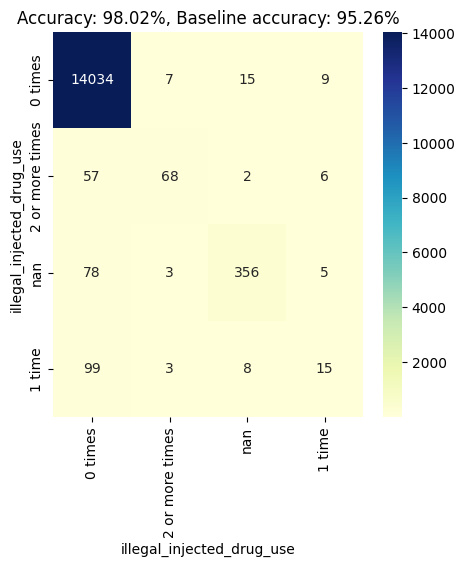

illegal_drugs_at_school


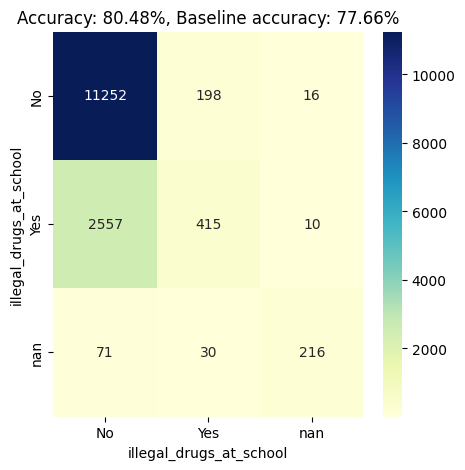

ever_sexual_intercourse


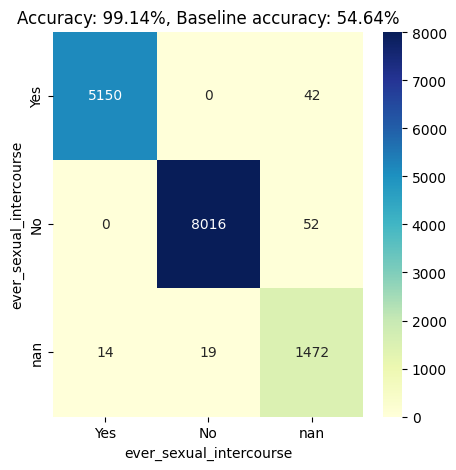

first_sex_intercourse


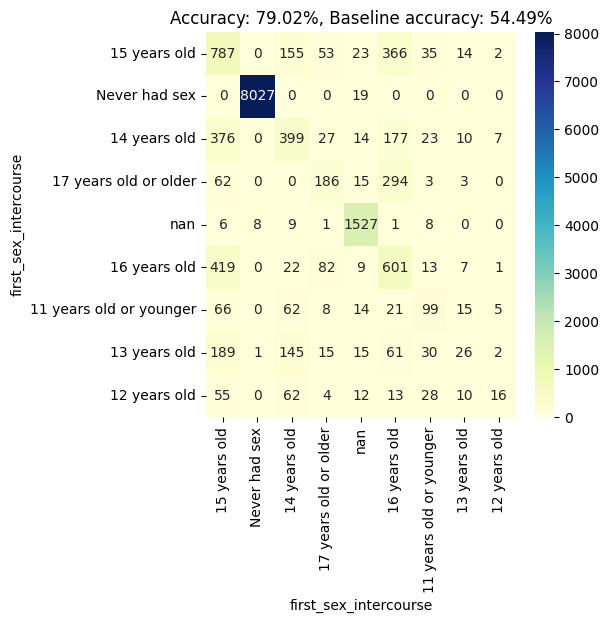

multiple_sex_partners


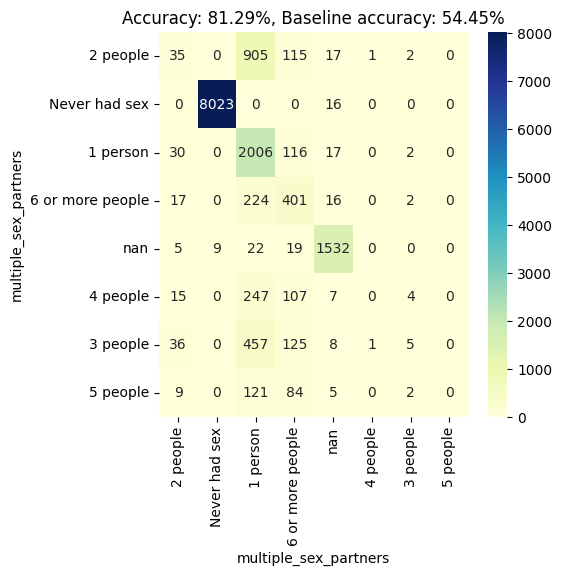

current_sexual_activity


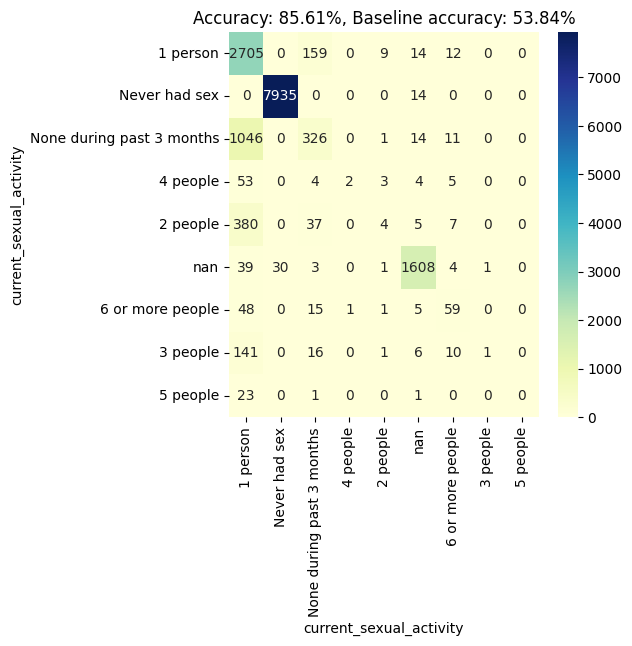

alcohol/drugs_at_sex


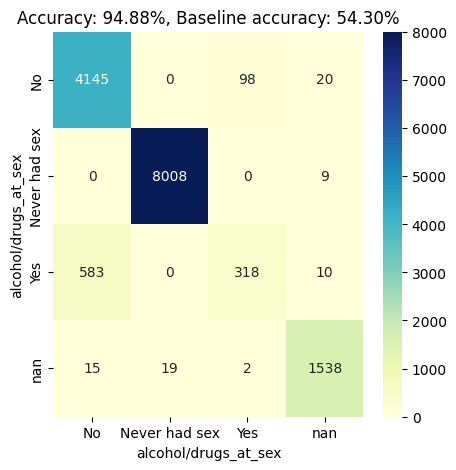

condom_use


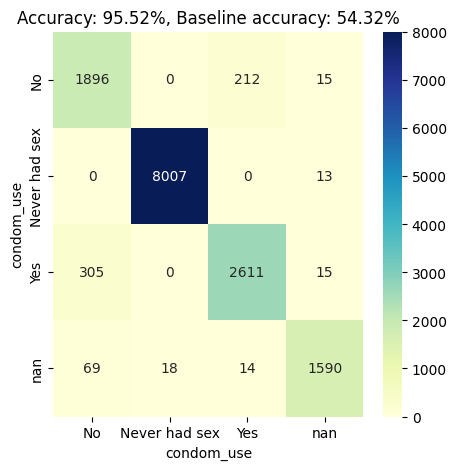

birth_control_pill_use


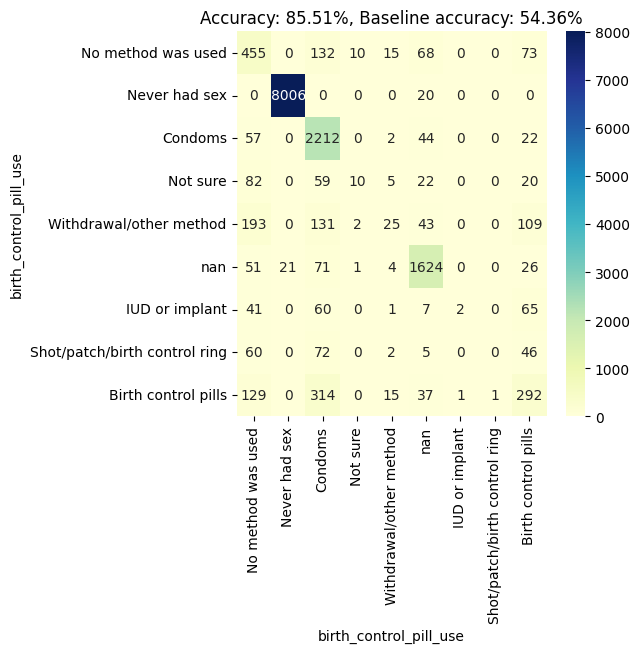

perception_of_weight


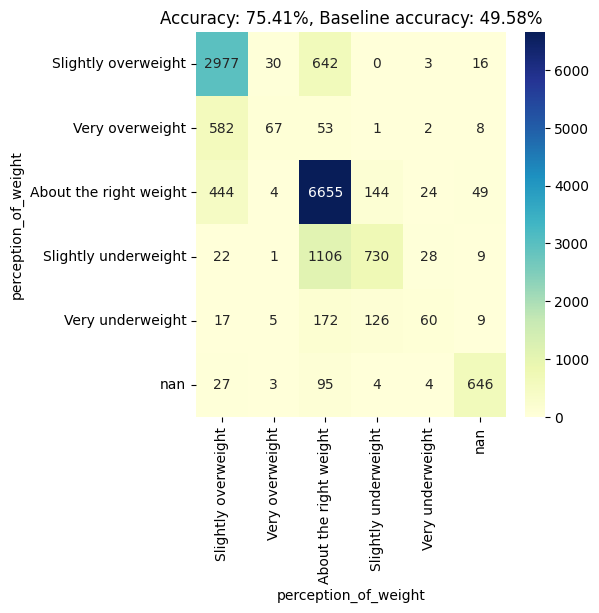

weight_loss


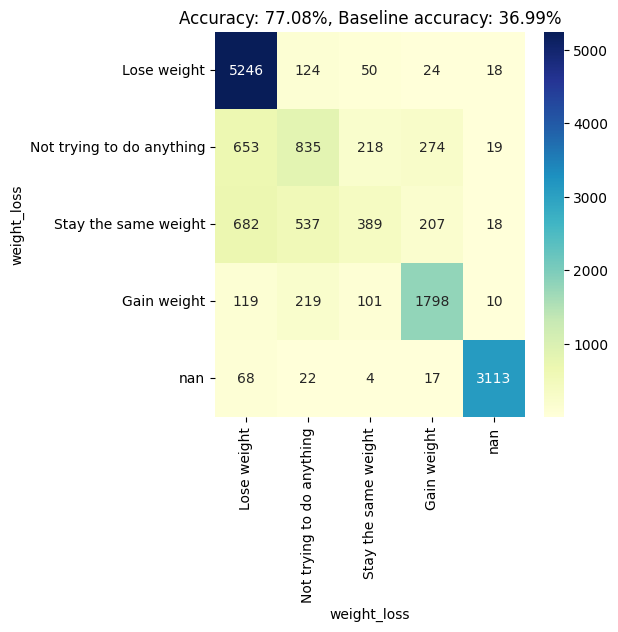

fruit_juice_drinking


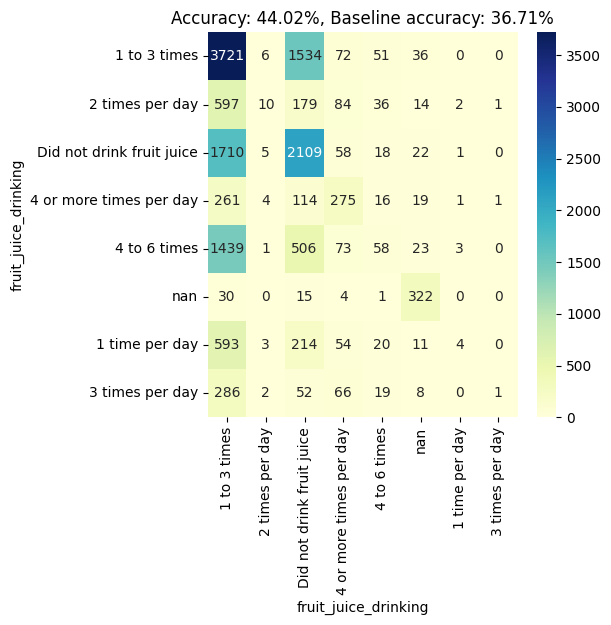

fruit_eating


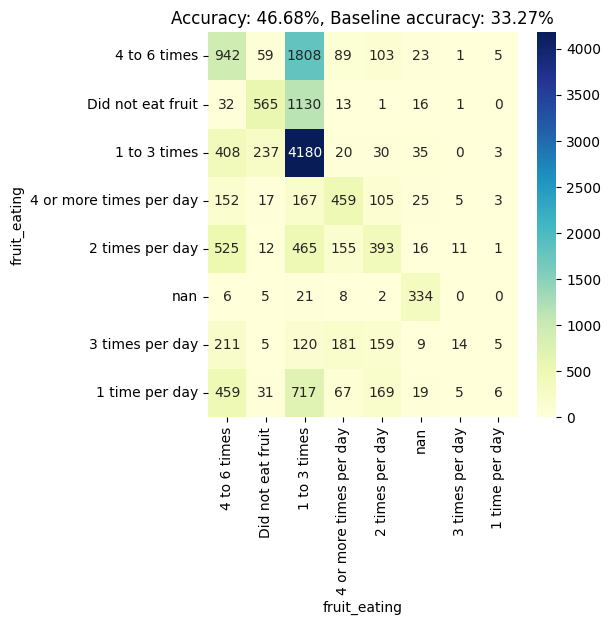

green _salad_eating


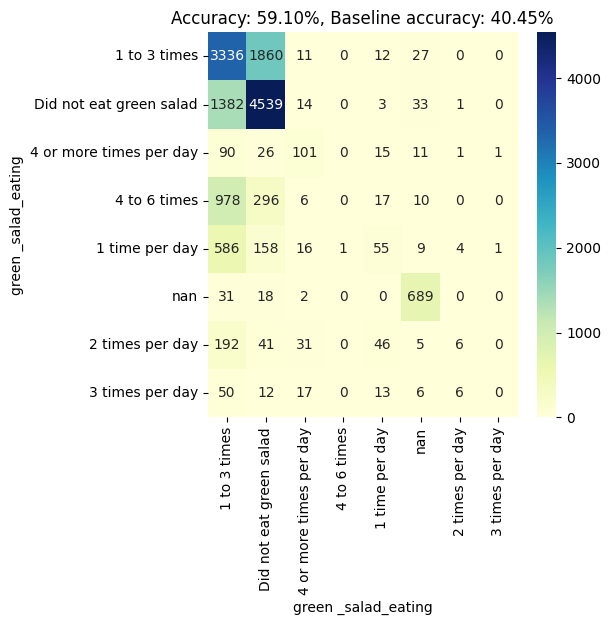

potato_eating


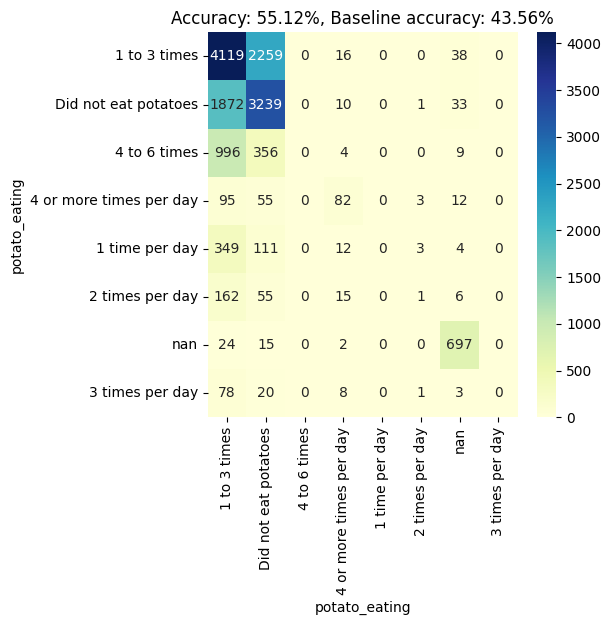

carrot_eating


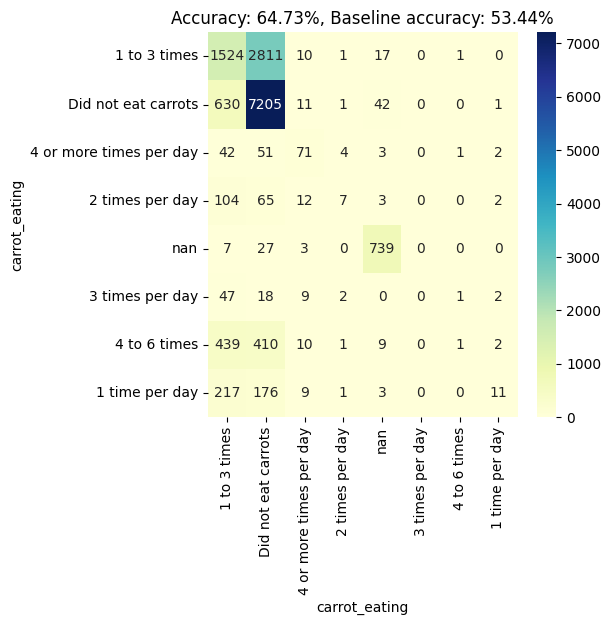

other_vegetable_eating


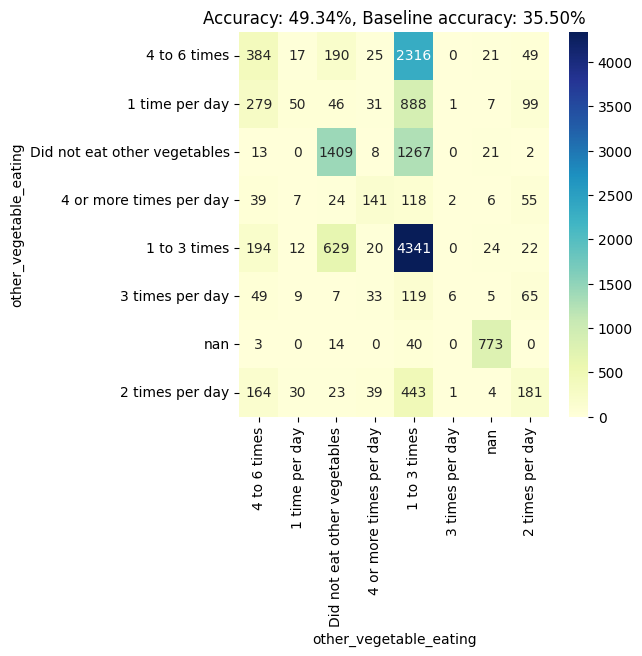

soda_drinking


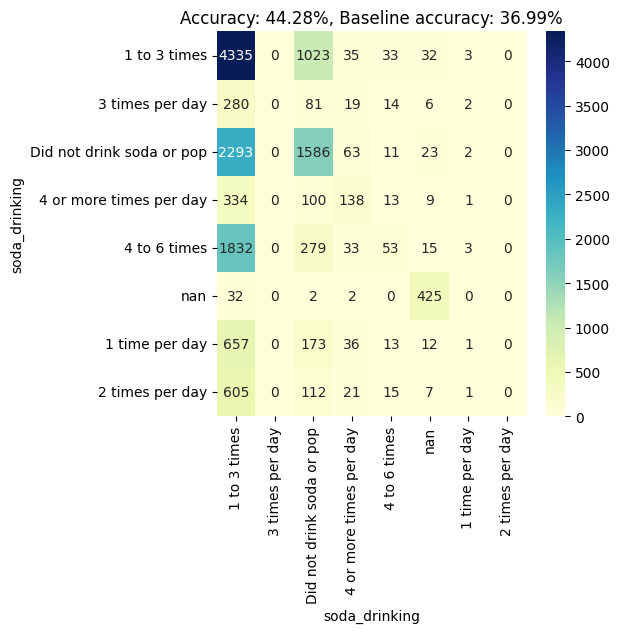

milk_drinking


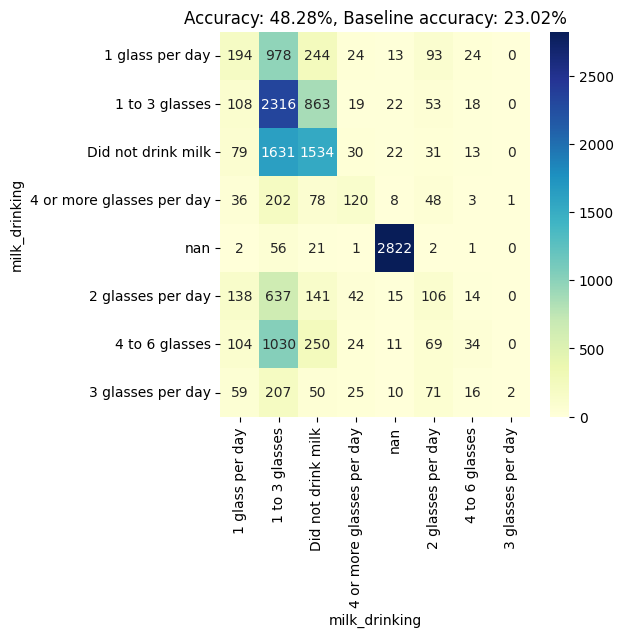

breakfast_eating


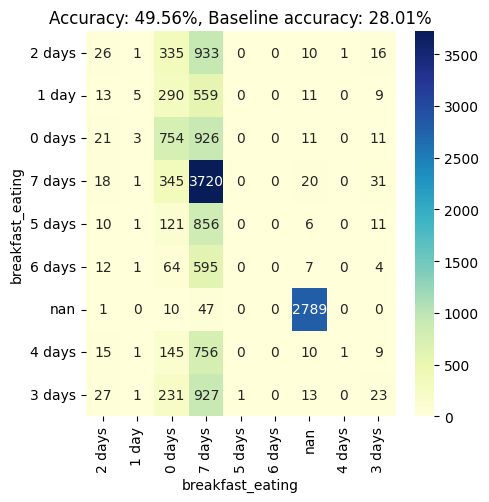

physical_activity


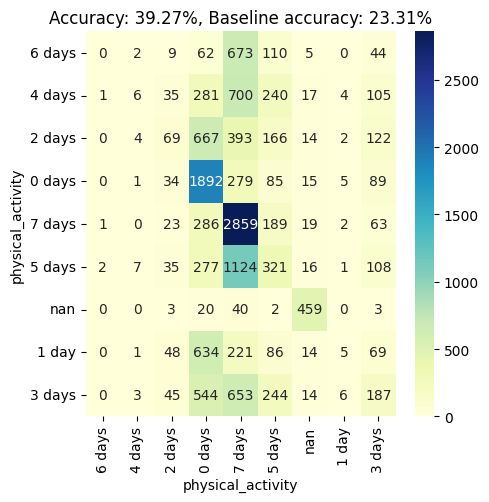

television_watching


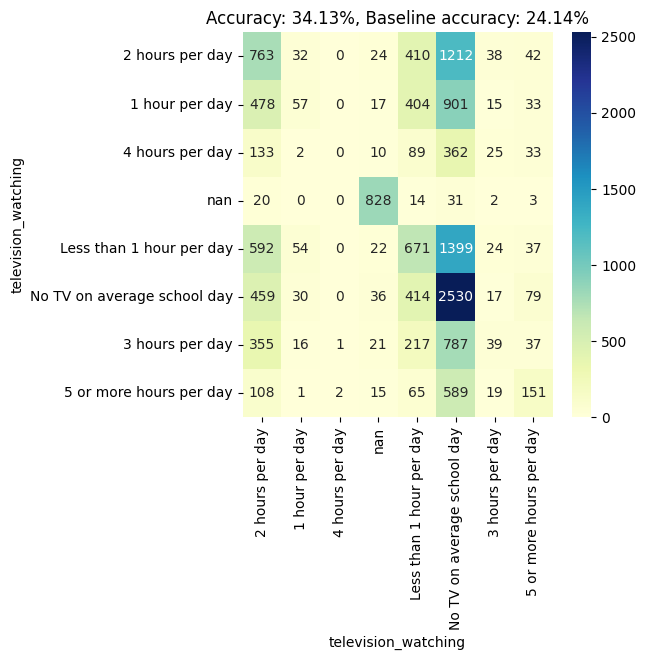

computer_not_school_work_use


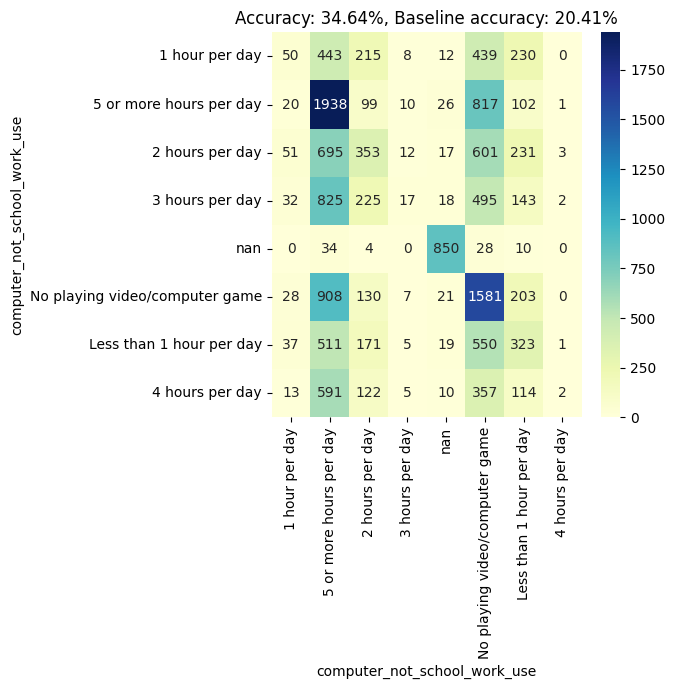

PE_attendance


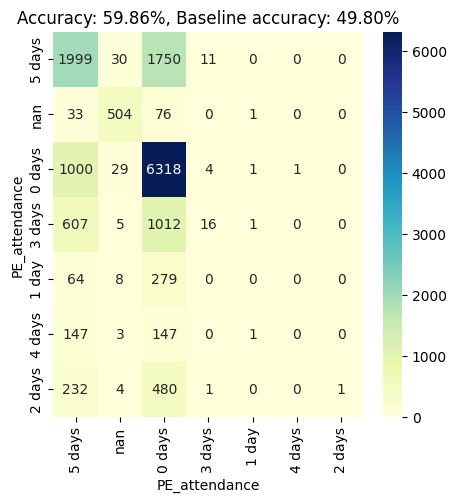

sports_team_participation


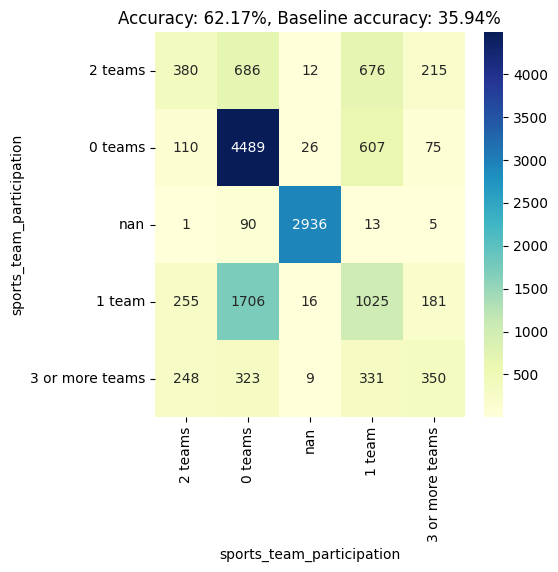

HIV_testing


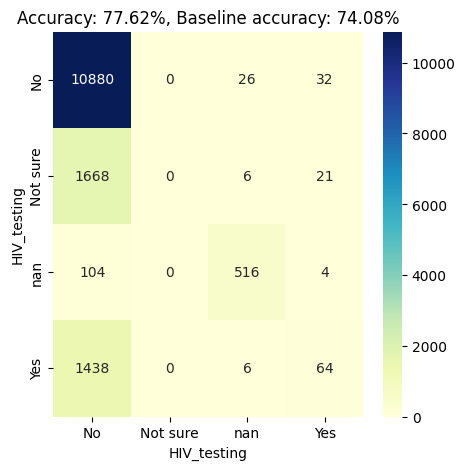

oral_health_care


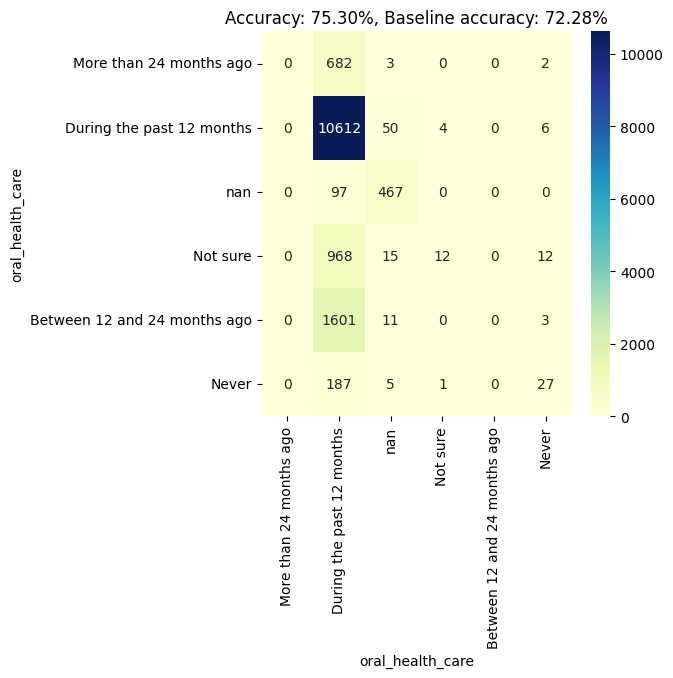

asthma


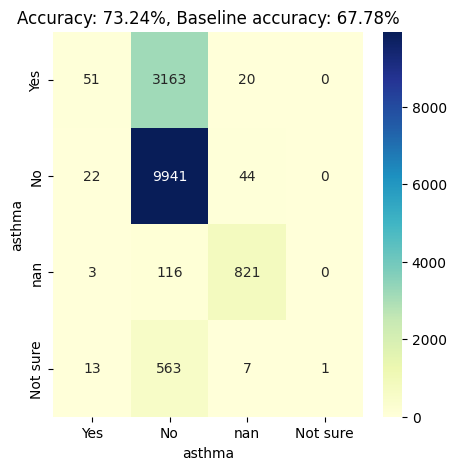

sleep_on_school_night


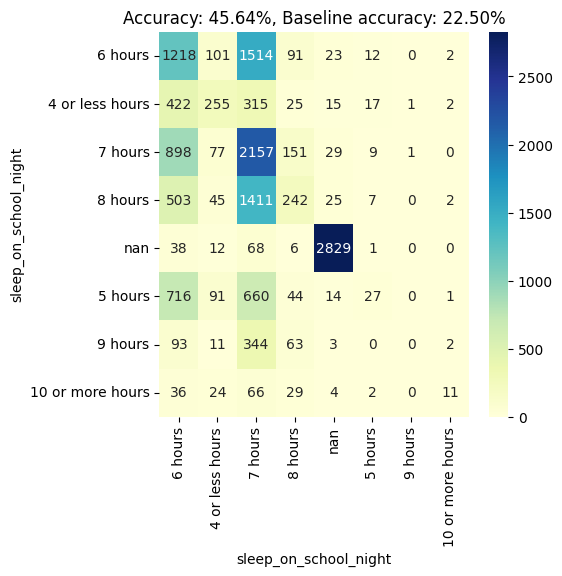

grades_in_school


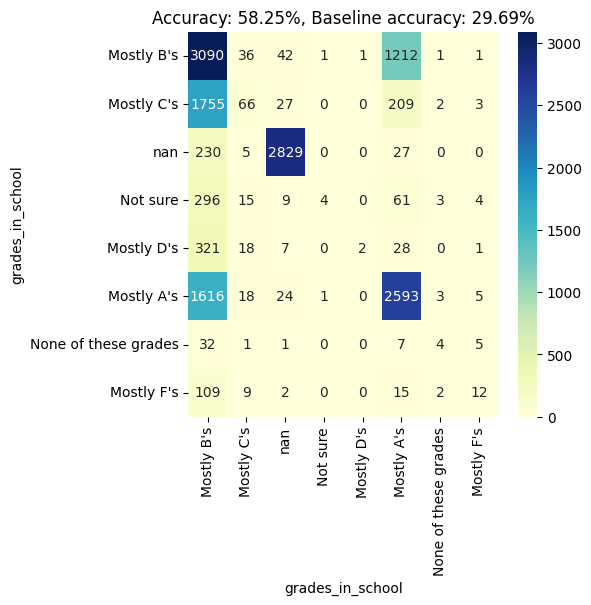

ever_used_LSD


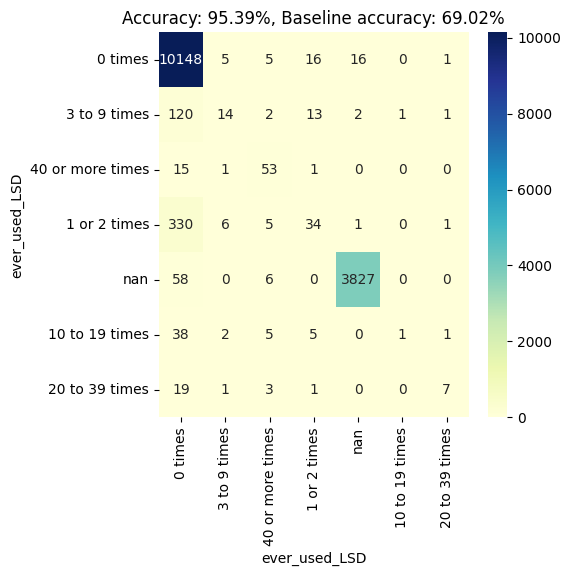

sports_drinks


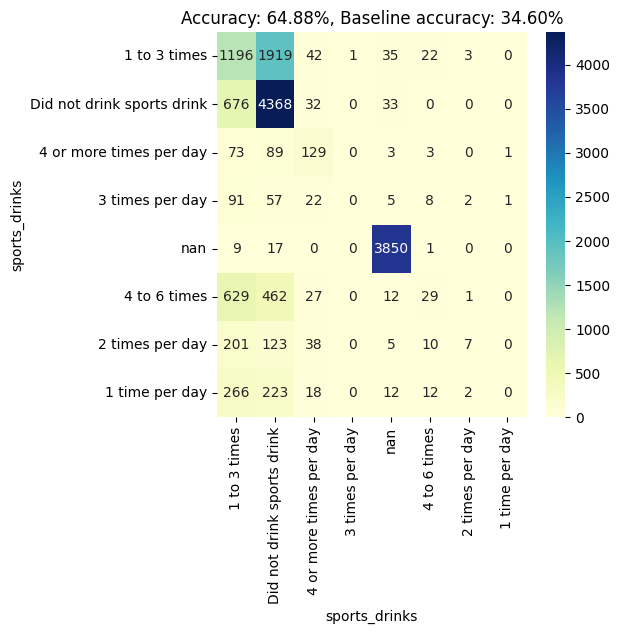

plain_water


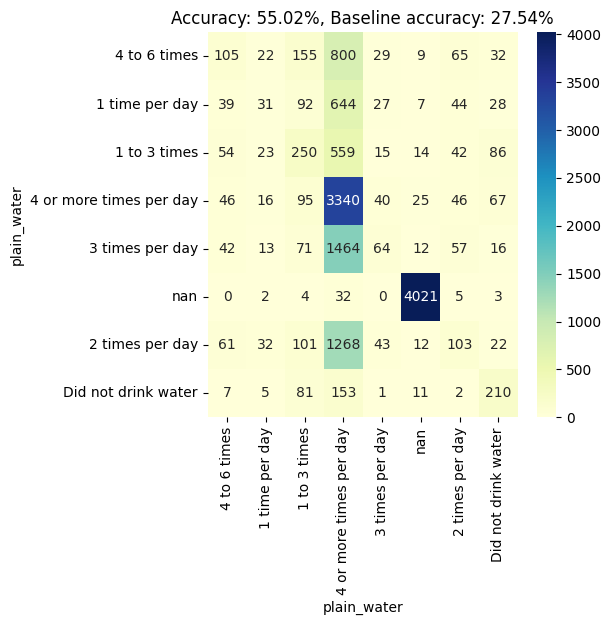

food_allergies


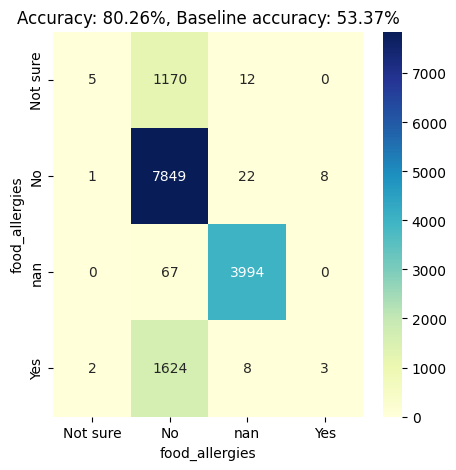

muscle_stregthening


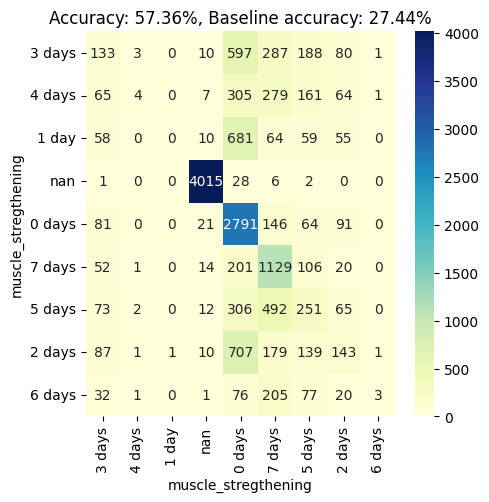

indoor_tanning


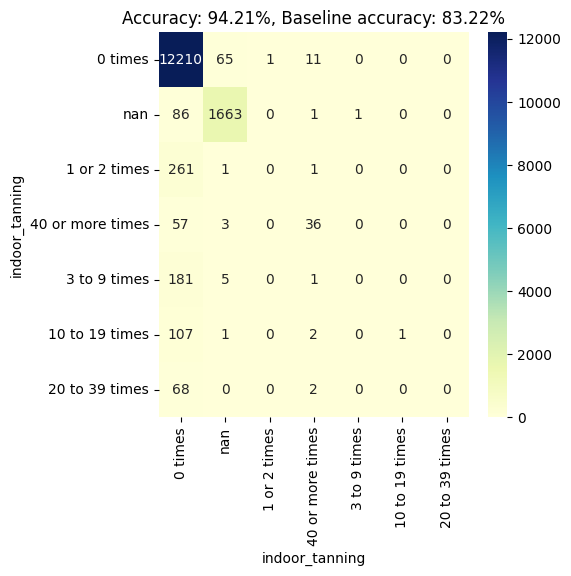

sunburn


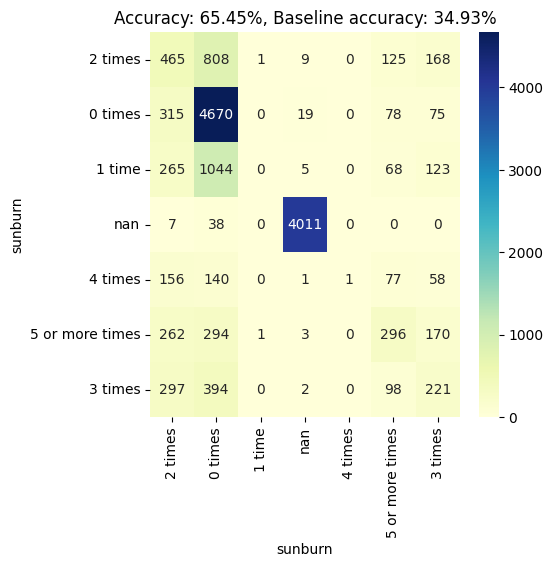

difficulty_concentrating


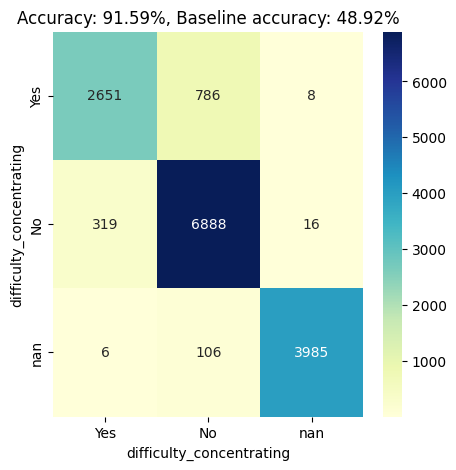

how_well_speak_English


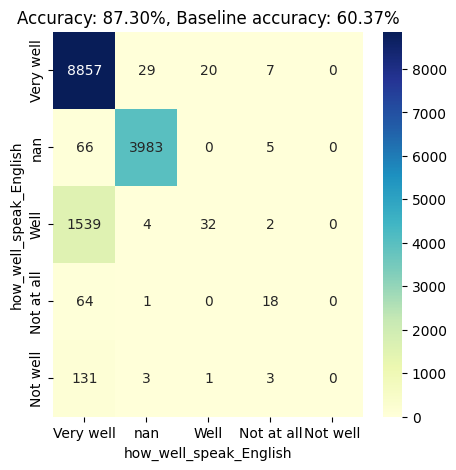

weight_cat


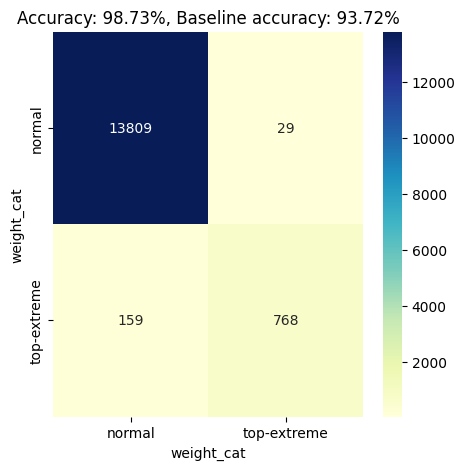

stheight_cat


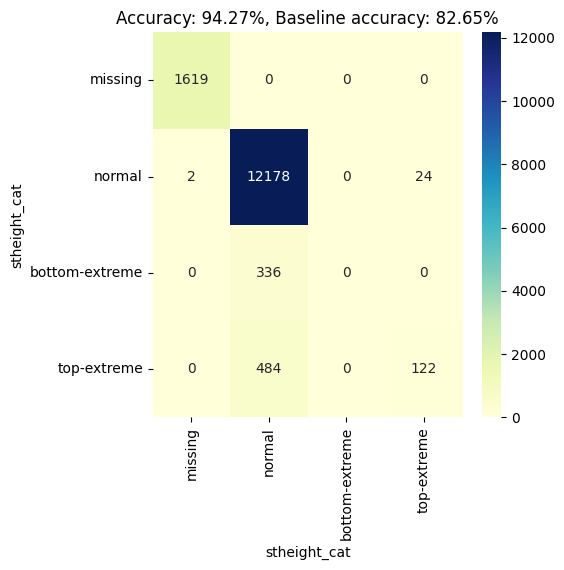

stweight_cat


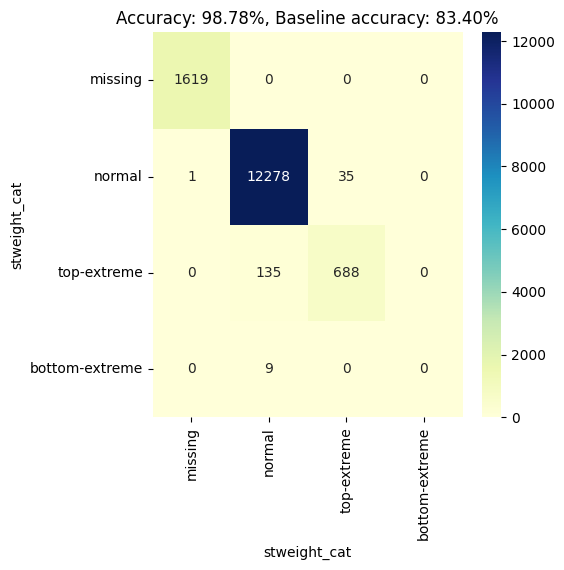

bmi_cat


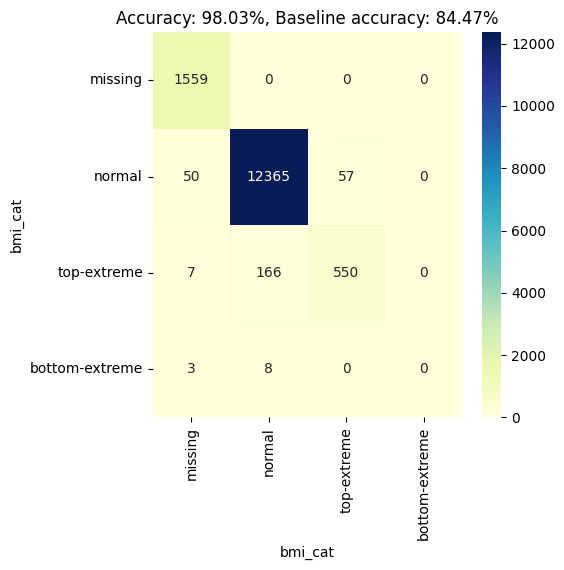

bmipct_cat


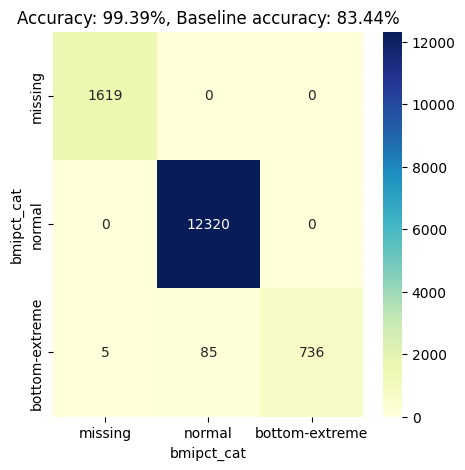

In [25]:
import matplotlib.pyplot as plt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_scatterplot_for_categorical(original_df, predicted_df, categ_attr):
    # Create a list of all unique categories present in the original data
    all_categories = original_df[categ_attr].unique()

    # Create the confusion matrix using crosstab
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])

    # Reindex the confusion matrix to include all categories in the original data
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    # Calculate accuracy
    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)
    accuracy = diagonal_sum / total_sum * 100

    # Calculate baseline accuracy
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100


    plt.figure(figsize=(5, 5))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Accuracy: {accuracy:.2f}%, Baseline accuracy: {baseline_accuracy:.2f}%")
    plt.show()
    return accuracy, baseline_accuracy

result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    a,b = create_scatterplot_for_categorical(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': a, 'baseline_accuracy': b }
    result.append(entry)

result = pd.DataFrame(result)




In [26]:
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.preprocessing import label_binarize

def calculate_extended_metrics(original_df, predicted_df, categ_attr):
    all_categories = original_df[categ_attr].unique()
    confusion_matrix = pd.crosstab(original_df[categ_attr], predicted_df[categ_attr])
    confusion_matrix = confusion_matrix.reindex(index=all_categories, columns=all_categories, fill_value=0)

    diagonal_sum = np.trace(confusion_matrix.values)
    total_sum = np.sum(confusion_matrix.values)

    accuracy = diagonal_sum / total_sum * 100
    baseline_accuracy = original_df[categ_attr].value_counts().max() / total_sum * 100

    # One-vs-All ROC and AUC
    y_true = label_binarize(original_df[categ_attr], classes=all_categories)
    y_pred = label_binarize(predicted_df[categ_attr], classes=all_categories)
    ova_roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovr', average='macro')

    return accuracy, baseline_accuracy, ova_roc_auc

# Example usage:
# accuracy, baseline_accuracy, ova_roc_auc = calculate_extended_metrics_without_prob(original_df, predicted_df, categ_attr)


result = []
for v in variable_types.keys():
  if variable_types[v] == 'categorical':
    print(v)
    if v.endswith("_cat"): continue # do not analyze numeric vars for now
    a,b, c = calculate_extended_metrics(project_data, tabular_from_predicted, v)
    entry = { 'variable': v, 'accuracy': round(a,1), 'baseline_accuracy': round(b,1), 'ova_auc': c, 'lift': round(a/b,2) }
    result.append(entry)

df = pd.DataFrame(result)

df['lift'].mean()



age
sex
grade
Hispanic_or_Latino
race
obese
overweight
sexual_identity
sex/sexual_contacts
sexid
sexid2
sexpart
sexpart2
seat_belt_use
riding_with_a_drinking_driver
drinking_and_driving
texting_and_driving
weapon_carrying
weapon_carrying_at_school
safety_concerns_at_school
threatened_at_school
physical_fighting
physical_fighting_at_school
forced_sexual_intercourse
sexual_dating_violence
physical_dating_violence
bullying_at_school
electronic_bullying
sad_or_hopeless
considered_suicide
made_a_suicide_plan
attempted_suicide
injurious_suicide_attempt
ever_cigarette_use
current_cigarette_use
smoking_amounts_per_day
electronic_vapor_product_use
current_electronic_vapor_product_use
current_cigar_use
ever_alcohol_use
initiation_of_alcohol_use
current_alcohol_use
source_of_alcohol
largest_number_of_drinks
ever_marijuana_use
initiation_of_marijuana_use
current_marijuana_use
ever_cocaine_use
ever_inhalant_use
ever_heroin_use
ever_methamphetamine_use
ever_ecstasy_use
ever_synthetic_marijuana_use
e

1.4949462365591397

In [22]:
df.sort_values(by='ova_auc', ascending=False).head(25)

variable  accuracy  baseline_accuracy   ova_auc  lift
6                     overweight      99.9               74.5  0.997630  1.34
56       ever_sexual_intercourse      99.1               54.6  0.992025  1.81
5                          obese      98.6               75.9  0.977744  1.30
12                      sexpart2      98.2               36.4  0.969924  2.70
8            sex/sexual_contacts      97.0               36.6  0.962175  2.65
61                    condom_use      95.5               54.3  0.958489  1.76
10                        sexid2      98.4               81.4  0.957760  1.21
11                       sexpart      97.9               36.4  0.939035  2.69
91      difficulty_concentrating      91.6               48.9  0.924429  1.87
9                          sexid      97.2               81.4  0.921435  1.19
7                sexual_identity      97.2               81.4  0.921246  1.19
1                            sex      98.2               51.0  0.913293  1.93
60          alcohol/drugs_at_sex      94.9               54.3  0.903433  1.75
2                          grade      89.8               26.6  0.900758  3.38
33            ever_cigarette_use      88.8               58.2  0.894515  1.52
3             Hispanic_or_Latino      93.1               42.4  0.889602  2.20
36  electronic_vapor_product_use      87.5               56.9  0.846380  1.54
32     injurious_suicide_attempt      95.1               66.2  0.843967  1.44
29            considered_suicide      93.3               81.2  0.811231  1.15
64                   weight_loss      77.1               37.0  0.804570  2.08
0                            age      76.4               25.0  0.788689  3.06
28               sad_or_hopeless      85.2               67.0  0.788610  1.27
26            bullying_at_school      90.0               80.9  0.778389  1.11
30           made_a_suicide_plan      92.7               84.7  0.775582  1.09
27           electronic_bullying      91.4               84.5  0.773829  1.08

In [27]:
df.sort_values(by=['ova_auc','baseline_accuracy'], ascending=True).head(25)

variable  accuracy  baseline_accuracy  \
14         riding_with_a_drinking_driver      83.5               83.2   
20                  threatened_at_school      93.4               93.2   
18             weapon_carrying_at_school      94.7               94.2   
22           physical_fighting_at_school      90.0               89.2   
37  current_electronic_vapor_product_use      78.5               75.7   
38                     current_cigar_use      91.4               90.0   
34                 current_cigarette_use      90.9               89.3   
80                      oral_health_care      75.3               72.3   
73                      breakfast_eating      49.6               28.0   
71                         soda_drinking      44.3               37.0   
75                   television_watching      34.1               24.1   
16                   texting_and_driving      68.7               38.1   
21                     physical_fighting      80.5               62.6   
65                  fruit_juice_drinking      44.0               36.7   
77                         PE_attendance      59.9               49.8   
76          computer_not_school_work_use      34.6               20.4   
82                 sleep_on_school_night      45.6               22.5   
68                         potato_eating      55.1               43.6   
83                      grades_in_school      58.2               29.7   
74                     physical_activity      39.3               23.3   
52          ever_synthetic_marijuana_use      93.1               90.7   
72                         milk_drinking      48.3               23.0   
46                 current_marijuana_use      82.0               78.0   
47                      ever_cocaine_use      94.9               93.4   
69                         carrot_eating      64.7               53.4   

     ova_auc  lift  
14  0.513183  1.00  
20  0.525068  1.00  
18  0.546489  1.01  
22  0.557695  1.01  
37  0.568360  1.04  
38  0.572531  1.02  
34  0.580856  1.02  
80  0.590459  1.04  
73  0.594044  1.77  
71  0.595506  1.20  
75  0.597322  1.41  
16  0.602356  1.80  
21  0.605518  1.29  
65  0.607024  1.20  
77  0.608329  1.20  
76  0.608694  1.70  
82  0.610349  2.03  
68  0.613049  1.27  
83  0.615539  1.96  
74  0.615579  1.68  
52  0.620995  1.03  
72  0.621662  2.10  
46  0.622758  1.05  
47  0.623336  1.02  
69  0.625922  1.21

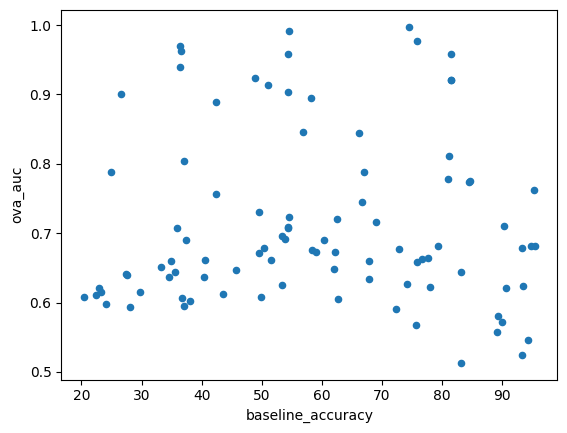

In [28]:
df.plot(x='baseline_accuracy', y='ova_auc', kind='scatter')
plt.show()